In [339]:
#libraries
import os 
import pandas as pd
import numpy as np 
import h5py
import math
import collections
import filecmp
from lxml import etree as ET
#import xml.etree.ElementTree as ET
import datetime
from collections import OrderedDict
#import pandasql as ps
from operator import itemgetter
import csv
from collections import Counter
#from google.colab import drive

import geopandas as gpd
#import pandasql as ps
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy
import fiona

from scipy.stats import kstest
from scipy.stats import mannwhitneyu


In [45]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')

In [3]:
import torch.nn as nn

In [ ]:
os.chdir('G:/My Drive/2021/Bias/recsys_test/ml-20m/psrc_test_01')
train = pd.read_csv('train.csv').to_numpy()

In [ ]:
torch.FloatTensor(train)

## PSRC simulation data extract

In [3]:
#Mount
#create drive content
#drive.mount('/content/drive', force_remount= True)
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')
#os.listdir()

# Create functions to open the tables in daysim_outputs.h5
def h5_to_data_frame(h5file, table_name):
    table = h5file[table_name]
    col_dict = {}
    #cols = ['hhno', 'hhtaz']
    for col in table.keys():
        if col == 'sov_ff_time':
            pass
        else:
            my_array = np.asarray(table[col]).astype('int')
        col_dict[col] = my_array.astype('int')
    return(pd.DataFrame(col_dict))

# Create functions to check the data
def print_dt_info(dt, dtname):
    print(dtname)
    print('shape', dt.shape)
    print('colnames', dt.columns)

In [4]:
# Read the daysim_outputs file
#hdf_file = h5py.File(r'/content/drive/My Drive/Colab Notebooks/Project/daysim_outputs.h5', "r")
hdf_file = h5py.File(r'daysim_outputs.h5', "r")

# output_dir = r'\\modelstation3\c$\\Workspace\sc_new_emp_SCEN3_2018'
print(hdf_file.keys())

<KeysViewHDF5 ['Household', 'HouseholdDay', 'Person', 'PersonDay', 'Tour', 'Trip']>


In [5]:
# Get the tables: trips, person, household, tours
# hhs and persons:
trips = h5_to_data_frame(hdf_file, 'Trip')
# get trips columns to use later
trips_columns = trips.columns

#get data
person = h5_to_data_frame(hdf_file, 'Person')
hh = h5_to_data_frame(hdf_file, 'Household')

tours = h5_to_data_frame(hdf_file, 'Tour')
person = person.merge(hh, how= 'left', left_on = 'hhno', right_on = 'hhno')

hh_day = h5_to_data_frame(hdf_file, 'HouseholdDay')
person_day = h5_to_data_frame(hdf_file, 'PersonDay')

# Build a new person id column in tours and trips table
#tours['person_id'] = tours['hhno'].astype(str) + '_' + tours['pno'].astype(str)
#trips['person_id'] = trips['hhno'].astype(str) + '_' + trips['pno'].astype(str)

# Build a new person id column in tours and trips table
#tours.keys()
#trips.keys()

#print zone id covered in person dataframe
#print('num taz covered', len(np.unique(person['zone_id'])))

In [6]:
#read PSRC shapefile
PSRC_taz =gpd.read_file('taz2010_revised.shp')
PSRC_taz.head(3)
#read the taz file with app-based count data

app_based_home = pd.read_csv('home_psrc_withtaz.csv') #each id with homes

In [7]:
#get # of identified count
app_based_home = pd.read_csv('home_psrc_withtaz.csv')

num_home_taz = app_based_home.groupby(by=['TAZ']).size().to_frame()
num_home_taz.reset_index(inplace=True)
num_home_taz.columns=['TAZ', 'app_count']

del(app_based_home)

In [9]:
#check the taz id
print('taz id from taz shapefile', np.unique(PSRC_taz['TAZ']),
     '# of tazs:', len(np.unique(PSRC_taz['TAZ'])))
print('taz id from PSRC od data', np.unique(person['zone_id']),
     '# of tazs:', len(np.unique(person['zone_id'])))
print('taz id from apps with home loc identified', np.unique(num_home_taz['TAZ']),
     '# of tazs:', len(np.unique(num_home_taz['TAZ'])))

taz id from taz shapefile [   1    2    3 ... 3698 3699 3700] # of tazs: 3700
taz id from PSRC od data [   0    1    2 ... 3697 3698 3699] # of tazs: 3443
taz id from apps with home loc identified [   1    2    3 ... 3698 3699 3700] # of tazs: 3700


In [41]:
print_dt_info(person, 'person')
print_dt_info(person_day, 'person_day')
#print_dt_info(hh, 'hh')
#print_dt_info(hh_day, 'hh_day')
#print_dt_info(tours, 'tours')
#print_dt_info(trips, 'trips')

person
shape (4053154, 44)
colnames Index(['hhno', 'id', 'pagey', 'pdiary', 'pgend', 'pno', 'ppaidprk', 'pproxy',
       'pptyp', 'psaudist', 'psautime', 'psexpfac', 'pspcl', 'pstaz', 'pstyp',
       'ptpass', 'puwarrp', 'puwdepp', 'puwmode', 'pwaudist', 'pwautime',
       'pwpcl', 'pwtaz', 'pwtyp', 'fraction_with_jobs_outside', 'hh515',
       'hhcu5', 'hhexpfac', 'hhftw', 'hhhsc', 'hhincome', 'hhoad', 'hhparcel',
       'hhptw', 'hhret', 'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs',
       'hownrent', 'hrestype', 'samptype', 'zone_id'],
      dtype='object')
person_day
shape (4053154, 31)
colnames Index(['beghom', 'day', 'endhom', 'esstops', 'estours', 'hbtours', 'hhno',
       'household_day_id', 'id', 'mestops', 'metours', 'mlstops', 'mltours',
       'pbstops', 'pbtours', 'pdexpfac', 'person_id', 'pno', 'restops',
       'retours', 'scstops', 'sctours', 'shstops', 'shtours', 'sostops',
       'sotours', 'uwtours', 'wbtours', 'wkathome', 'wkstops', 'wktours'],
      dtype='object

In [96]:
### Trip data processing
#get specific person id
#hhno + pno
#hhnopno_id = (trip_revised.hhno.astype('str')+'_'+trip_revised['pno'].astype('str')).values

#np.unique(trip_revised.hhno)
person['hhnopno_id'] = person.hhno.astype('str')+'_'+person.pno.astype('str')
person = person[person['hhnopno_id'].isin(hhnopno_id)]

len(person[person['zone_id'].isin(selected_taz)])

trip_revised = trip_revised.sort_values(by=['hhno', 'pno'])
person = person.sort_values(by=['hhno', 'pno'])

trip_revised[['hhno','pno','otaz', 'dtaz','deptm','arrtm','travtime','day','tour']]

trip_revised['tmdiff'] = trip_revised['arrtm'] - trip_revised['deptm']

trip_revised['diffvstravel'] = (trip_revised['tmdiff']==trip_revised['travtime'])

revised_val = lambda x: 1 if x==True else 0
trip_revised['diffvstravel'] = trip_revised['diffvstravel'].apply(revised_val)

trips = trip_revised[['hhno','pno','otaz', 'dtaz','deptm','arrtm','travtime','tmdiff','diffvstravel','day','tour', 'mode']]

def get_departtime(deptm, arrtm):
    #check departure time format
    #in minutes or hours*100+minutes
    de_index = deptm%100
    ar_index = arrtm%100
    if de_index < 60 and ar_index<60:
        #convert to seconds
        return(deptm//100*3600+de_index*60)
    else:
        return(deptm//60*3600+deptm%60*60)
    
de_ar_time = trips[['deptm', 'arrtm']].values
sumo_departure_time = []
for t in de_ar_time:
    det, art = t
    sumo_departure_time.append(get_departtime(det, art))
    
trips['sumo_deptm'] = sumo_departure_time
#convert depart time 
trips = trips.sort_values(by=['sumo_deptm'])

selected_taz_index =  lambda x: 0 if x in selected_taz else 1

ori_index = trips.otaz.apply(selected_taz_index).values
dest_index = trips.dtaz.apply(selected_taz_index).values
taz_index = ori_index+dest_index

print('# of taz both in downtown Seattle')
print(np.count_nonzero(taz_index))
print('total trips we have')
print(len(taz_index))
trips['taz_index'] = taz_index

#current input for sumo downtown Seattle
'''print('# of taz both in downtown Seattle')
print(np.count_nonzero(taz_index))
print('total trips we have')
print(len(taz_index))
trips['taz_index'] = taz_index'''

del(ori_index)
del(dest_index)
del(taz_index)

trips['personid'] = trips.hhno.astype('str')+'_'+trips.pno.astype('str')
trips = trips.sort_values(by=['hhno','pno'])
home_index = lambda x: 1 if x in selected_taz else 2

person['home_indt'] = person['zone_id'].apply(home_index)
person.sort_values(by=['home_indt', 'hhno', 'pno'])

person.to_csv('person_inorpass_dtSeattle_sim.csv')
trips.to_csv('trips_inorpass_dtSeattle_sim.csv')

person_trip_counts = trips.groupby(by=['personid']).size().to_frame()
person_trip_counts.reset_index(inplace=True)
person_trip_counts.columns = ['personid','trip_counts']

selected_person = person_trip_counts['personid'][person_trip_counts['trip_counts']==6].values[:100]

trips[trips['personid'].isin(selected_person)].to_csv('trip_trip_counts6_top100.csv')

trips[trips['personid'].isin(selected_person)]

with open('vehroute.txt', 'w') as file:
    file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    file.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n')
    file.write('<vType id="passenger" vClass="passenger" accel="3.2" color="yellow" decel="3.5" length="4" maxSpeed="200" lcStrategic="2000" lcSpeedGain="5" lcCooperative="1" lcSpeedGainLookahead="5" minGap="1.5" cc1="0.9" cc2="4" cc3="-8" cc4="-0.1" cc5="0.1" cc6="11.44" cc7="0.25" cc8="3.5" cc9="1.5"/>\n')
    #<trip type="passenger" id="5000_542_0:300.0:324.0" depart="18000.0" fromTaz="5000" toTaz="542" departLane="free" departSpeed="max" />
    file.write('')
    
    file.write('</routes>')
file.close()    

with open('personroute.txt', 'w') as f:
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    f.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n')
    
    #<person id="200" depart="14401.01" departPos="random">
    #    <walk from="490227753#2" to="8111488#0" arrivalPos="random"/>
    #</person>
    f.write('</routes>')

# of taz both in downtown Seattle
929072
total trips we have
1459959


## App-based data check

In [9]:
#check the different taz
app_based_taz = np.unique(app_based_home['TAZ'])
psrc_sim_taz = np.unique(person['zone_id'])

print(len(app_based_taz))
print(len(psrc_sim_taz)
      
#through the checking, it is noticed that the psrc simulation data started at 0
#while actual taz started at 1
#thus we convert the actual taz, letting it start at 1
app_based_taz -= 1

In [55]:
#get the taz number that only in one of the data
app_diff_sim = []
sim_diff_app = []
def get_diff_taz(check_arr, compare_arr, taz_lst):
    for taz_id in check_arr:
        if taz_id not in compare_arr:
            taz_lst.append(taz_id)
    taz_lst = np.array(taz_lst)
    
    #convert to actual taz id
    taz_lst += 1
    
    return(taz_lst)

app_diff_sim = get_diff_taz(app_based_taz, psrc_sim_taz, app_diff_sim)
sim_diff_app = get_diff_taz(psrc_sim_taz, app_based_taz, sim_diff_app)

#print(len(app_diff_sim)) = 230
#print(len(sim_diff_app)) = 19

# it is found tha app_diff_sim and sim_diff_app are not empty
# thus we compare the data with taz

#check with actual taz
taz = gpd.read_file('taz2010_revised.shp')

psrc_taz = np.unique(taz['TAZ'])
psrc_taz -= 1 

app_missed_taz = get_diff_taz(psrc_taz, app_based_taz, [])
sim_missed_taz = get_diff_taz(psrc_taz, psrc_sim_taz, [])
print(len(app_missed_taz))
print(len(sim_missed_taz))

#check psrc sim trip
sim_trip_taz = list(np.unique(trips['otaz']))
sim_trip_d_taz = list(np.unique(trips['dtaz']))
for tazid in sim_trip_d_taz:
    if tazid not in sim_trip_taz:
        sim_trip_taz.append(tazid)
        
get_diff_taz(psrc_taz, sim_trip_taz, [])

In [67]:
#it is found that even for trips, there might be missing taz (with no trips identified)
#but the area is sensible using QGIS

#psrc sim doesn't treat any taz with only hotels as home location
#which is not true in comparison with app-inferred home based on the home identification
#algorithm

#select taz both locate in app-inferred home and psrc sim home
crossed_taz = []
for tazid in app_based_taz:
    if tazid in psrc_sim_taz:
        crossed_taz.append(tazid)
        
print(len(crossed_taz))
#thus, we only focused on the crossed taz
revised_crossed_taz = list(np.array(crossed_taz)+1)
app_based_home_crossed = app_based_home[app_based_home['TAZ'].isin(revised_crossed_taz)]
home_num_origin = len(app_based_home['newid'].values)
crossed_home_num = len(app_based_home_crossed['newid'].values)
print('original identified home num =', home_num_origin)
print('crossed identified home num =', crossed_home_num)
print('diff above =',home_num_origin-crossed_home_num)

## result
#original identified home num = 110880
#crossed identified home num = 108662
#diff above = 2218

person_crossed = person[person['zone_id'].isin(crossed_taz)]
persom_num_origin = len(person['id'].values)
crossed_person_num = len(person_crossed['id'].values)
print('original identified home num =', persom_num_origin)
print('crossed identified home num =', crossed_person_num)
print('diff above =', persom_num_origin-crossed_person_num)

## result
#original identified home num = 4053154
#crossed identified home num = 4051164
#diff above = 1990

#save the missed id
missed_app_id_home = app_based_home[~app_based_home.isin(revised_crossed_taz)]
missed_app_id_home = missed_app_id_home['newid'].values

missed_sim_id_home = person[~person['zone_id'].isin(crossed_taz)]
missed_sim_id_home = person['id'].values

#delete redundant data
del(app_missed_taz)
del(sim_missed_taz)
del(app_diff_sim)
del(sim_diff_app)
del(app_based_home)
del(person)

3424


In [93]:
#revised data frame now become
person_crossed['TAZ'] = person_crossed['zone_id'] + 1
person_crossed.head(3)

C:\Users\29700\AppData\Local\Temp\ipykernel_20808\187326765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_crossed['TAZ'] = person_crossed['zone_id'] + 1


,hhno,id,pagey,pdiary,pgend,pno,ppaidprk,pproxy,pptyp,psaudist,...,hhsize,hhtaz,hhuni,hhvehs,hhwkrs,hownrent,hrestype,samptype,zone_id,TAZ
0,1,1,69,-1,2,1,1,-1,1,-1,...,1,3594,0,1,-1,1,1,-1,3593,3594
1,16,16,65,-1,2,1,1,-1,3,-1,...,1,3594,0,1,-1,1,1,-1,3593,3594
2,8,8,52,-1,2,1,0,-1,1,-1,...,1,3592,0,1,-1,1,2,-1,3591,3592


In [92]:
app_based_home_crossed['zone_id'] = app_based_home_crossed['TAZ']-1
app_based_home_crossed.head(3)

C:\Users\29700\AppData\Local\Temp\ipykernel_20808\1478643089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_based_home_crossed['zone_id'] = app_based_home_crossed['TAZ']-1


,Unnamed: 0,newid,lat,lon,geometry,index_right,TAZ,COUNTY_FIP,COUNTY_NM,Area,zone_id
0,0,38343,47.596215,-121.979614,POINT (-121.979614333 47.5962145003),1951,1952,33,King,2182469.507,1951
1,1,13824,47.836323,-122.296098,POINT (-122.296098429 47.8363228733),2513,2514,61,Snohomish,513657.111,2513
2,2,18910,47.222268,-122.493760,POINT (-122.493760032 47.22226772560001),2950,2951,53,Pierce,1276868.336,2950


Findings

* app-based data (not specifically focuses on the population)
home identification covers people who are:
    * workers who stayes up late at their work building
    * non-residentials stays in hotels ("hotel population")

* PSRC simulation data (missing the "travel population" and stays up late at work buildings)


In [49]:
#compare the person info with the ACS estimates?
#spatial join taz and census block group
#since the taz and cbg are defined differently, the spatial join can be biased
#especially for those taz crossed over one cbg.
#we use the joined the information to check the total pop of PSRC simualtion, in
#comparison with the ACS (in cbg level)

In [96]:
person_crossed.shape

(4051164, 45)

In [97]:
len(np.unique(person_crossed['id']))

4051164

## Data aggregation

In [102]:
#aggregate the sum count/pop based on the app-based dt and psrc simulation dt
#for app-based data, get the total count for each taz
app_based_home_crossed = app_based_home_crossed.drop(columns = ['Unnamed: 0'])
app_based_count = app_based_home_crossed.groupby(['TAZ']).size().to_frame()
app_based_count.reset_index(inplace=True)
app_based_count.columns = ['TAZ', 'appid_count']
app_based_count = app_based_count.join(taz, lsuffix='TAZ', rsuffix='TAZ', how='left')
#app_based_count = app_based_count.drop(columns = ['TAZTAZ'])
app_based_count.columns = ['TAZ', 'appid_count', 'TAZ1', 'COUNTY_FIP', \
                           'COUNTY_NM', 'Area','geometry']
app_based_count = app_based_count.drop(columns = ['TAZ1'])

#get sum of person in each taz based on the psrc simulation data
person_crossed_count = person_crossed.groupby('TAZ').size().to_frame()
person_crossed_count.reset_index(inplace=True)
person_crossed_count.columns = ['TAZ', 'psrc_sum']

#join the two dataset
app_based_count = app_based_count.join(person_crossed_count, lsuffix='TAZ', rsuffix='TAZ', how='left')
#app_based_count = app_based_count.drop(columns = ['TAZTAZ'])

#tide the data and deleter redundant data set
app_based_count.columns = ['TAZ', 'appid_count', 'COUNTY_FIP', 'COUNTY_NM',\
                           'Area', 'geometry','TAZ1', 'psrc_sum']
app_based_count.drop(columns=['TAZ1'])
del(person_crossed_count)

Index(['newid', 'lat', 'lon', 'geometry', 'index_right', 'TAZ', 'COUNTY_FIP',
       'COUNTY_NM', 'Area', 'zone_id'],
      dtype='object')


KstestResult(statistic=0.9345794392523364, pvalue=0.0)
MannwhitneyuResult(statistic=279469.0, pvalue=0.0)
KstestResult(statistic=0.038843457943925234, pvalue=0.011406431404904918)
MannwhitneyuResult(statistic=5791489.0, pvalue=0.38944280045125024)


(array([1768., 1145.,  346.,  102.,   44.,   11.,    4.,    2.,    0.,
           2.]),
 array([1.0000e+00, 9.9540e+02, 1.9898e+03, 2.9842e+03, 3.9786e+03,
        4.9730e+03, 5.9674e+03, 6.9618e+03, 7.9562e+03, 8.9506e+03,
        9.9450e+03]),
 <BarContainer object of 10 artists>)

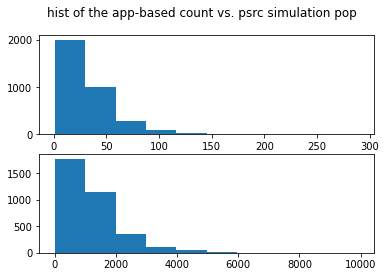

In [407]:
#check the pop
print(kstest(app_based_count['appid_count'].values, app_based_count['psrc_sum'].values))
print(mannwhitneyu(app_based_count['appid_count'].values, app_based_count['psrc_sum'].values))
#scaled
print(kstest(app_based_count['appid_count'].values/(np.sum(app_based_count['appid_count'].values/np.sum(app_based_count['psrc_sum'].values))), app_based_count['psrc_sum'].values))
print(mannwhitneyu(app_based_count['appid_count'].values/(np.sum(app_based_count['appid_count'].values/np.sum(app_based_count['psrc_sum'].values))), app_based_count['psrc_sum'].values))
#both shown the data is not statistically similar (not scaled)
#wilcoxon test shows the data pattern is similar

fig, axs = plt.subplots(2)
fig.suptitle('hist of the app-based count vs. psrc simulation pop')
axs[0].hist(app_based_count['appid_count'].values)
axs[1].hist(app_based_count['psrc_sum'].values)

In [187]:
#check the pop with the ACS survey
#taz_ct_join = 

## Explore the demographic factors
### demographic factors
(pptyp, pagey, pgend, hhincome, hhownrent, hhrestype)\
pptyp: person type\
1= full time worker, 2 =part time worker, 3=non-worker age 65+, 4 = other non-working adult, 5 = university student, 6 = grade school student/child age 16+, 7 = child age 5-15, 8 = child age 0-4. 

pagey: age in years\
age group: 
<18, 18-29, 30-49, 50-64, >65 (need to be decoded)

pgend: Gender (1=male, 2=female, 9=missing data for estimation)

hhincome: household income (The household annual income, in integer dollars. (A negative value is interpreted as missing data in DaySim estimation mode.)
[Source](https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system#:~:text=A%20family%20earning%20between%20%2432%2C048,more%20than%20%24373%2C894%20are%20rich).

| INCOME GROUP       | INCOME (2019, $) | 
| :---               | :---             |
| Poor or near-poor  | 32,048 or less   |
| Lower-middle class | 32,048 - 53,413  |
| Middle class       | 53,413 - 106,827 |
| Upper-middle class | 106,827 - 373,894|
| Rich               | 373,894 and up   |

hhownrent: Household own versus rent status. (This could be optional as input, as it is not currently used in the DaySim model code.) 

hhrestype: Household residence building type. (This could be optional as input, as it is not currently used in the DaySim model code.)  

household inocme from PEW

| INCOME GROUP  | INCOME (2019, $) | 
| :---          | :---             |
|level 1        | 49,000 or less   |
|level 2        | 50,000 - 74,999  |
|level 3        | 75,000 or more |


### detailed work/study type
(pwtyp, pstyp, hhwkrs, hhvehs, hhftw, hhptw, hhret, hhoad, hhuni, hhhsc)\
pwtyp: Worker type (0=non-worker, 1=full time worker, 2=part time worker)\
pstyp: student type (0=non-student, 1=full time student, 2=part time student if known – part-time distinction not used in DaySim code)\
Hhwkrs: the number of workers in the household*\
Hhvehs: the number of auto in the household*\
Hhftw:The number of HH members with person type=full-time worker.   (This could be optional as input, as it is computed by DaySim.)\
Hhptw: The number of HH members with person type=part-time worker.   (This could be optional as input, as it is computed by DaySim.)\
Hhret: The number of HH members with person type=retired adult.   (This could be optional as input, as it is computed by DaySim.)\
hhoad: The number of HH members with person type=other non-working adult.   (This could be optional as input, as it is computed by DaySim.)\
hhuni:The number of HH members with person type=university student.   (This could be optional as input, as it is computed by DaySim.)\
hhhsc:The number of HH members with person type=grade school student age 16+.   (This could be optional as input, as it is computed by DaySim.)

### travel based factors
(pwautime, pwaudist, psautime, psaudist, puwmode, puwarrp, puwdepp, ptpass, ppaidprk)
#### work
pwautime: The 1-way peak auto travel time between the residence and usual work parcels (a real number of minutes, -1 if no usual work location. Could be optional as input, used as output for calibration.)\
pwaudist: The 1-way peak auto distance between the ...\
psautime: The 1-way peak auto travel time between the residence and usual school parcels (a real number of minutes, -1 if no usual school location. Could be optional as input, used as output for calibration.)\
psaudist: The 1-way peak auto travel distance between the residence and usual school parcels (a real number of miles, -1 if no usual school location. Could be optional as input, used as output for calibration.)

#### mode
puwmode: The usual mode used to work

#### time
puwarrp: The usual arrival period at work\
puwdepp: The usual departure period from work\
ptpass: Transit pass ownership (0=no, 1=yes. This is predicted by DaySim, so could be an optional input in application mode.)\
ppaidprk: Worker has to pay to park at work (0=no, 1=yes.   This is predicted by DaySim, so could be an optional input in application mode.)



In [10]:
#check the data
print(person.columns)
print(np.unique(person[['hhincome']][person['hhincome']<0]))
print(person[['hhincome']][person['hhincome']<0].shape)

Index(['hhno', 'id', 'pagey', 'pdiary', 'pgend', 'pno', 'ppaidprk', 'pproxy',
       'pptyp', 'psaudist', 'psautime', 'psexpfac', 'pspcl', 'pstaz', 'pstyp',
       'ptpass', 'puwarrp', 'puwdepp', 'puwmode', 'pwaudist', 'pwautime',
       'pwpcl', 'pwtaz', 'pwtyp', 'fraction_with_jobs_outside', 'hh515',
       'hhcu5', 'hhexpfac', 'hhftw', 'hhhsc', 'hhincome', 'hhoad', 'hhparcel',
       'hhptw', 'hhret', 'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs',
       'hownrent', 'hrestype', 'samptype', 'zone_id'],
      dtype='object')
[-6500 -5600 -5500 -5100 -5000 -4800 -4600 -4100 -3400 -1900 -1600 -1500
  -800  -100    -1]
(1787, 1)


In [11]:
def get_dt_summary(dt, var_lst, ignore_count=True):
    if ignore_count == True:
        print(dt[var_lst].describe(include='all').iloc[1:][:])
    else:
        print(dt[var_lst].describe(include='all'))
        
print('demo factors')
get_dt_summary(person_crossed,['pagey', 'pgend', 'pptyp', 'hhincome', 'hownrent', 'hrestype'])
print('detailed work/study type')
get_dt_summary(person_crossed,['pwtyp', 'pstyp', 'hhwkrs', 'hhvehs', 'hhftw', 'hhptw', 'hhret',\
                               'hhoad', 'hhuni', 'hhhsc'])
print('travel based factors')
get_dt_summary(person_crossed, ['pwautime', 'pwaudist', 'psautime', 'psaudist',\
                                'puwmode', 'puwarrp',  'puwdepp', 'ptpass', 'ppaidprk'])

demo factors


NameError: name 'person_crossed' is not defined

In [38]:
#decode the data
#for age, pagey
#<18, 18-29, 30-49, 50-64, >65
def decode_age(age_var):
    if age_var<18 and age_var>=0:
        return(0)
    elif age_var>=18 and age_var<=29:
        return(1)
    elif age_var>=30 and age_var<=49:
        return(2)
    elif age_var>=50 and age_var<=64:
        return(3)
    elif age_var>=65:
        return(4)
    else:
        return('nan')
    
#for household income, hhincome
#Poor or near-poor 32,048 or less
#Lower-middle class 32,048 - 53,413
#Middle class 53,413 - 106,827
#Upper-middle class 106,827 - 373,894
#Rich 373,894 and up
def decode_income(income_var):
    if income_var != -1:
        if income_var<=0:
            return(0)
        elif income_var>0 and income_var<32048:
            return(1)
        elif income_var>=32048 and income_var<53413:
            return(2)
        elif income_var>=53413 and income_var<106827:
            return(3)
        elif income_var>=106827 and income_var<373894:
            return(4)
        else:
            return(5)    
    else:
        return(-1)
    
def decode_income_3level(income_var):
    if income_var != -1:
        if income_var<=0:
            return(1)
        elif income_var>0 and income_var<32048:
            return(1)
        elif income_var>=32048 and income_var<53413:
            return(1)
        elif income_var>=53413 and income_var<106827:
            return(2)
        elif income_var>=106827 and income_var<373894:
            return(2)
        else:
            return(3)    
    else:
        return(-1)
    
def decode_income_pew(income_var):
    if income_var != -1:
        if income_var<=0:
            return(1)
        elif income_var>0 and income_var<=49999:
            return(1)
        elif income_var>=50000 and income_var<=74999:
            return(2)
        elif income_var>=75000:
            return(3)
    else:
        return(-1)
    
person['deage'] = person['pagey'].apply(lambda x: decode_age(x))
person['deincome'] = person['hhincome'].apply(lambda x: decode_income(x))
#a simple defination of income level
person['deincome3'] = person['hhincome'].apply(lambda x: decode_income_3level(x))
person['deincomepew'] = person['hhincome'].apply(lambda x: decode_income_pew(x))

In [13]:
print(person[['deage']].astype(str).describe())
print(person.groupby(['deage']).size())

print(person[['deincome']].astype(str).describe())
print(person.groupby(['deincome']).size())

print(person[['deincome3']].astype(str).describe())
print(person.groupby(['deincome3']).size())

print(person[['deincomepew']].astype(str).describe())
print(person.groupby(['deincomepew']).size())


#since for income, the unit is per household
#thus we check the income level info in hh dt
hh['deincome'] = hh['hhincome'].apply(lambda x: decode_income(x))

hh['deincomepew'] = hh['hhincome'].apply(lambda x: decode_income_pew(x))

print(hh[['deincome']].astype(str).describe())
print(hh.groupby(['deincome']).size())

print(hh[['deincomepew']].astype(str).describe())
print(hh.groupby(['deincomepew']).size())

print(hh['hownrent'].astype(str).describe())
print(hh.groupby(['hownrent']).size())
print(hh['hrestype'].astype(str).describe())
print(hh.groupby(['hrestype']).size())

          deage
count   4053154
unique        5
top           2
freq    1084998
deage
0     863424
1     641141
2    1084998
3     891168
4     572423
dtype: int64
       deincome
count   4053154
unique        7
top           4
freq    1601651
deincome
-1       1306
 0      24993
 1     482797
 2     519183
 3    1255008
 4    1601651
 5     168216
dtype: int64
       deincome3
count    4053154
unique         4
top            2
freq     2856659
deincome3
-1       1306
 1    1026973
 2    2856659
 3     168216
dtype: int64
       deincomepew
count      4053154
unique           4
top              3
freq       2512404
deincomepew
-1       1306
 1     916240
 2     623204
 3    2512404
dtype: int64
       deincome
count   1605263
unique        7
top           4
freq     539969
deincome
-1       653
 0     15477
 1    264018
 2    235061
 3    495309
 4    539969
 5     54776
dtype: int64
       deincomepew
count      1605263
unique           4
top              3
freq        873818
deincome

In [14]:
hh.columns

Index(['fraction_with_jobs_outside', 'hh515', 'hhcu5', 'hhexpfac', 'hhftw',
       'hhhsc', 'hhincome', 'hhno', 'hhoad', 'hhparcel', 'hhptw', 'hhret',
       'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs', 'hownrent', 'hrestype',
       'samptype', 'zone_id', 'deincome', 'deincomepew'],
      dtype='object')

### Findings from the data
* for demographic features 
    * pgend and hhincome has missing values (val = -1)
    * hhincome can be negative (mim = -6,500)
    * age across from 0 to 94, the most pop in age group locates age in (30-49)
    * missing value exists in income, the most pop in income group locates upper-middle class 106,827 - 373,894
    * female pop approximately equals to male pop
* for travel based features
    * usual mode for person are mostly unknown, except transit pass ownership (ptpass) and paid for park (ppaidprk)
* Missings
    * missing values for number of workers in the household

### Data processing

In [15]:
hh.columns

Index(['fraction_with_jobs_outside', 'hh515', 'hhcu5', 'hhexpfac', 'hhftw',
       'hhhsc', 'hhincome', 'hhno', 'hhoad', 'hhparcel', 'hhptw', 'hhret',
       'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs', 'hownrent', 'hrestype',
       'samptype', 'zone_id', 'deincome', 'deincomepew'],
      dtype='object')

In [16]:
person.columns

Index(['hhno', 'id', 'pagey', 'pdiary', 'pgend', 'pno', 'ppaidprk', 'pproxy',
       'pptyp', 'psaudist', 'psautime', 'psexpfac', 'pspcl', 'pstaz', 'pstyp',
       'ptpass', 'puwarrp', 'puwdepp', 'puwmode', 'pwaudist', 'pwautime',
       'pwpcl', 'pwtaz', 'pwtyp', 'fraction_with_jobs_outside', 'hh515',
       'hhcu5', 'hhexpfac', 'hhftw', 'hhhsc', 'hhincome', 'hhoad', 'hhparcel',
       'hhptw', 'hhret', 'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs',
       'hownrent', 'hrestype', 'samptype', 'zone_id', 'deage', 'deincome',
       'deincome3', 'deincomepew'],
      dtype='object')

In [17]:
#person_crossed.groupby(['TAZ', 'deincome'])
def rename_col(var_name, var_val):
    colname_lst = []
    for i in range(len(var_val)):
        colname_lst.append(var_name+'_'+str(var_val[i]))
    return(colname_lst)

def tide_dt(dt, var_name):
    var_val = np.unique(dt[var_name])
    var_number = len(var_val)
    var_df = dt.groupby(['TAZ', var_name]).size().unstack(fill_value=0)
    colname = rename_col(var_name, var_val)
    var_df.columns = colname
    var_df.reset_index(inplace=True)
    return(var_df)

def join_dt(l_suf, r_suf, dt, joindt):
    dt = dt.join(joindt, lsuffix=l_suf, rsuffix=r_suf, how='left')
    dt = dt.drop(columns = ['TAZ'+r_suf])
    return(dt)

In [18]:
#sum all the factor in different groups
def return_demo_var_sum(dt, income_col):
    test_dt = tide_dt(dt, 'deage')
    test_dtt_dt = join_dt('', '2', test_dt, tide_dt(dt, 'pgend'))
    test_dt = join_dt('', '2', test_dt, tide_dt(dt, 'pptyp'))
    test_dt = join_dt('', '2', test_dt, tide_dt(dt, income_col))
    test_dt = join_dt('', '2', test_dt, tide_dt(dt, 'hownrent'))
    test_dt = join_dt('', '2', test_dt, tide_dt(dt, 'hrestype'))
    print(test_dt.columns)
    return(test_dt)

In [19]:
person['TAZ']=person['zone_id']+1

#previous input: deincome3
test_dt = return_demo_var_sum(person, 'deincomepew')

Index(['TAZ', 'deage_0', 'deage_1', 'deage_2', 'deage_3', 'deage_4', 'pptyp_1',
       'pptyp_2', 'pptyp_3', 'pptyp_4', 'pptyp_5', 'pptyp_6', 'pptyp_7',
       'pptyp_8', 'deincomepew_-1', 'deincomepew_1', 'deincomepew_2',
       'deincomepew_3', 'hownrent_0', 'hownrent_1', 'hownrent_2', 'hrestype_0',
       'hrestype_1', 'hrestype_2', 'hrestype_3', 'hrestype_4'],
      dtype='object')


In [69]:
#check the missing values
a = list(person['id'][person['pgend']==-1].values)
b = list(person['id'][person['deincome']==-1].values)
a.extend(b)
print('# of missings', len(np.unique(a)))
print('% of missings', len(np.unique(a))/len(np.unique(person['id'])))

# of missings 1476
% of missings 0.00036416084856385914


In [22]:
del(test_dt)

In [ ]:
#check variable groups
print(np.unique(person['pgend']))
print(np.unique(person['deage']))
print(np.unique(person['deincome3']))
print(np.unique(person['deincomepew']))

In [40]:
#decode the group
#age
#gender
#income (convert 2 3groups)
#demo_col = ['pgend', 'deage', 'income']
#income = 1: deincome, 2:deincome3 3:deincomepew
def assign_demo_num(dt, income_applied):
    #delete missing values
    processed_dt = dt[(dt['pgend']!=-1) & (dt['deincome']!=-1)]
    if income_applied == 1:
        processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \
        (processed_dt['deage'])*3 + (processed_dt['deincome3'])
    elif income_applied == 2:
        processed_dt['demo_level'] = (processed_dt['pgend']-1)*30 + \
        (processed_dt['deage'])*6 + (processed_dt['deincome'])
    elif income_applied == 3:
        processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \
        (processed_dt['deage'])*3 + (processed_dt['deincomepew'])
    elif income_applied == 4:
        processed_dt['demo_level'] = (processed_dt['deage'])*3 +\
        (processed_dt['deincomepew'])
    return(processed_dt)

def save_dtforest(dt, joindt, savename, income_applied, return_index=True, save_dt=True):
    processed_dt = assign_demo_num(dt, income_applied)
    processed_dt = tide_dt(processed_dt, 'demo_level')
    processed_dt = join_dt('', '2', processed_dt, joindt)
    #processed_dt.drop(columns = 'TAZ1')
    if save_dt == True:
        processed_dt.to_csv(savename)
    if return_index == True:
        return(processed_dt)

In [25]:
test_dt = save_dtforest(person, num_home_taz, 'demo_group_dt_psrc.csv', 3, True, False)
test_dt.head(3)

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\3173161693.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \


,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,...,demo_level_22,demo_level_23,demo_level_24,demo_level_25,demo_level_26,demo_level_27,demo_level_28,demo_level_29,demo_level_30,app_count
0,1,2,5,106,0,1,15,3,3,110,...,3,2,97,3,13,131,11,8,104,17
1,2,36,20,149,19,20,45,27,45,185,...,70,57,235,77,18,100,99,36,48,30
2,3,39,2,44,82,12,143,88,43,153,...,252,47,129,157,35,89,396,55,61,66


In [408]:
sim_appdt = save_dtforest(person, num_home_taz, 'demo_group_dt_psrc.csv', 1, True, False)
sim_appdt.head(3)

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\1158223603.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \


,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,...,demo_level_22,demo_level_23,demo_level_24,demo_level_25,demo_level_26,demo_level_27,demo_level_28,demo_level_29,demo_level_30,app_count
0,1,2,96,15,0,16,0,3,94,19,...,3,85,14,7,122,18,14,106,3,17
1,2,38,165,2,19,61,4,32,206,19,...,76,265,21,80,109,6,105,78,0,30
2,3,39,46,0,82,155,0,99,183,2,...,264,162,2,163,117,1,405,107,0,66


In [57]:
sim_dt = assign_demo_num(person, 3)
sim_dt = sim_dt[['id', 'demo_level', 'TAZ']]

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\1158223603.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \


In [60]:
sim_dt['demo_level']

0          30
1          29
2          25
3          29
4          29
           ..
4053149    24
4053150    18
4053151     3
4053152     3
4053153    18
Name: demo_level, Length: 4051678, dtype: int64

In [90]:
np.random.seed(42)
pure_sample = np.random.binomial(1, 0.03, sim_dt.shape[0])
sim_dt['sample_nodemo'] = pure_sample

In [115]:
np.random.binomial(1, 0.03, 1)[0]

0

In [409]:
#drop column draft code
#sim_dt = sim_dt.drop(['sample_ndemo'], axis=1)
#input_per=sim_per
def sim_dt_based_ondemoper(x, input_per):
    #N = len(input_per)
    sample_r = input_per[-1]
    p = input_per[x]*sample_r
    return(np.random.binomial(1, p, 1)[0])

def get_sim_data(sim_dt, demo_col, sim_col, save_name, save_idx=True, return_idx = False):
    processed_dt = tide_dt(sim_dt, 'demo_level')
    sim_sample_dt = sim_dt[[sim_col, 'TAZ']].groupby(by=['TAZ']).sum()
    sim_sample_dt.reset_index(inplace=True)
    
    test_dt = join_dt(' ', '2', processed_dt, sim_sample_dt)
    if save_idx == True:
        test_dt.to_csv(save_name)
        print('data saved to csv, done')
    if return_idx == True:
        return(test_dt)
    
get_sim_basedonBI = lambda x: sim_dt_based_ondemoper(x,sim_per)

In [166]:
sim_per = list(fit_results_wp['mean'].values)

In [168]:
sim_dt['sim_basedonBI'] = sim_dt['demo_level'].apply(get_sim_basedonBI)

In [169]:
get_sim_data(sim_dt, 'demo_level', 'sim_basedonBI', 'sim_dt_basedon_BI_test.csv')

data saved to csv, done


In [144]:
fit_results_wop = pd.read_csv('model_all_wop.csv', nrows=31)
fit_results_wp = pd.read_csv('model_all_wp.csv', nrows=31)
fit_results_wphh = pd.read_csv('model_all_wphh.csv', nrows=31)

In [149]:
fit_results_wop.head(3)

,Unnamed: 0,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
0,P[1],0.012200,0.000014,0.002196,0.010058,0.010637,0.011524,0.013034,0.018236,23819.203457,0.999918
1,P[2],0.014494,0.000030,0.004458,0.010113,0.011295,0.013115,0.016228,0.026523,22259.939690,1.000011
2,P[3],0.013008,0.000020,0.003024,0.010075,0.010859,0.012092,0.014171,0.021185,21909.586188,0.999998


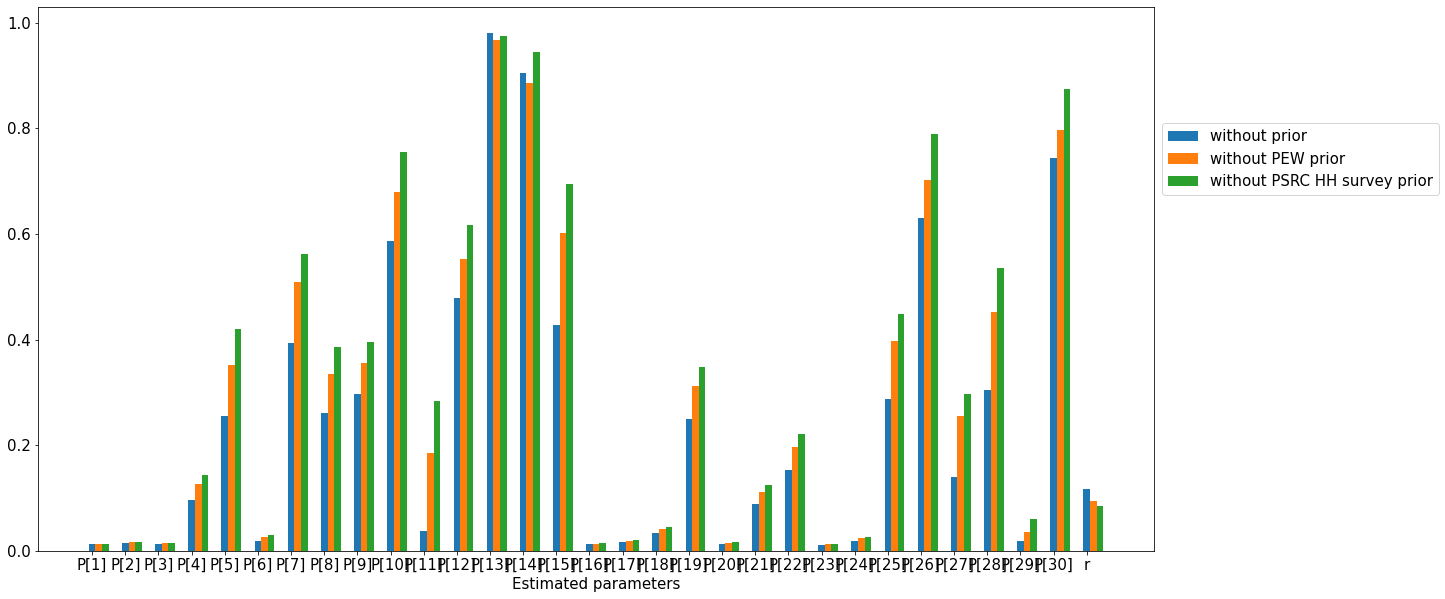

In [199]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})
x_val = list(range(1, 31))

N = fit_results_wop.shape[0]
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind,  fit_results_wop['mean'], 0.2, label='without prior')
bar2 = plt.bar(ind+width,  fit_results_wp['mean'], 0.2, label='without PEW prior')
bar3 = plt.bar(ind+width*2,  fit_results_wphh['mean'], 0.2, label='without PSRC HH survey prior')

plt.xlabel('Estimated parameters')
plt.xticks(np.arange(fit_results_wop.shape[0]), fit_results_wop['Unnamed: 0'].values)

plt.legend(bbox_to_anchor=(1, 0.8))

In [216]:
psrc_hh_per = [0.3425791, 0.4486967, 0.4616777, 0.6360929, 0.8331295, 0.8572323, 
               0.6176205, 0.808935, 0.8323379, 0.5674873, 0.7432726, 0.7647758, 
               0.4494189, 0.5886313, 0.6056606, 0.3390872, 0.4441231, 0.4569718,
               0.6296093, 0.8246375, 0.8484946, 0.6113251, 0.8006896, 0.8238539, 
               0.561703, 0.7356965, 0.7569805, 0.444838, 0.5826314, 0.5994872]

In [442]:
#fit_model_previous
fit_model_p_psrchh = pd.read_csv('model_all_wphh_income.csv', nrows=31)

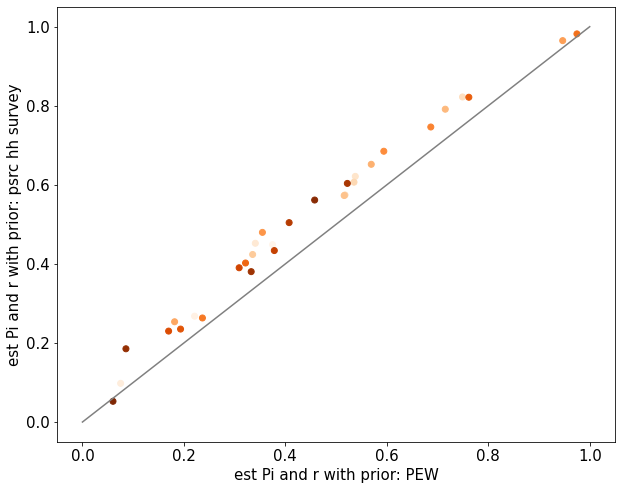

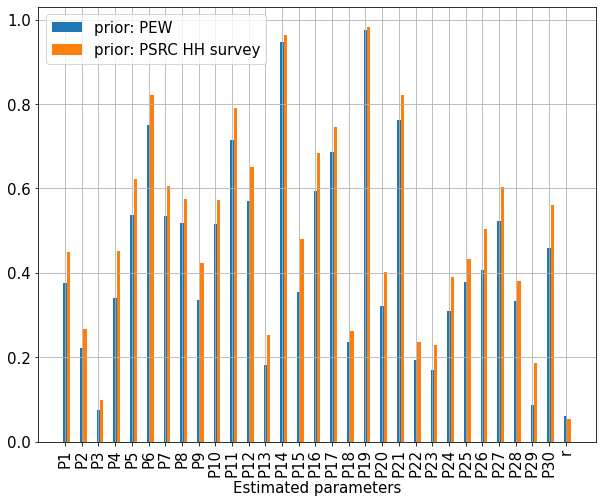

In [514]:
plt.rcParams["figure.figsize"] = (10,8)
x_val = list(range(0, 31))
fig = plt.figure(1)
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax3.scatter(fit_model_previous['mean'], fit_model_p_psrchh['mean'], c=x_val, cmap='Oranges')
ax3.plot([0, 1], [0,1], 'grey')
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.set_xlabel('est Pi and r with prior: PEW')
ax3.set_ylabel('est Pi and r with prior: psrc hh survey')

plt.figure(2)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})
x_val = list(range(1, 31))
N = fit_model_previous.shape[0]
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind,  fit_model_previous['mean'], 0.2, label='prior: PEW')
bar2 = plt.bar(ind+width, fit_model_p_psrchh['mean'], 0.2, label='prior: PSRC HH survey')

plt.xlabel('Estimated parameters')
plt.xticks(np.arange(fit_results_wop.shape[0]), xtick_val, rotation=90)
plt.grid()

plt.legend()

In [454]:
print(kstest(fit_model_previous['mean'], fit_model_p_psrchh['mean']))
print(mannwhitneyu(fit_model_previous['mean'], fit_model_p_psrchh['mean']))

KstestResult(statistic=0.25806451612903225, pvalue=0.2560450207654439)
MannwhitneyuResult(statistic=392.0, pvalue=0.21537717301984338)


Text(0, 0.5, 'rate of diff demo groups based on PSRC HH survey')

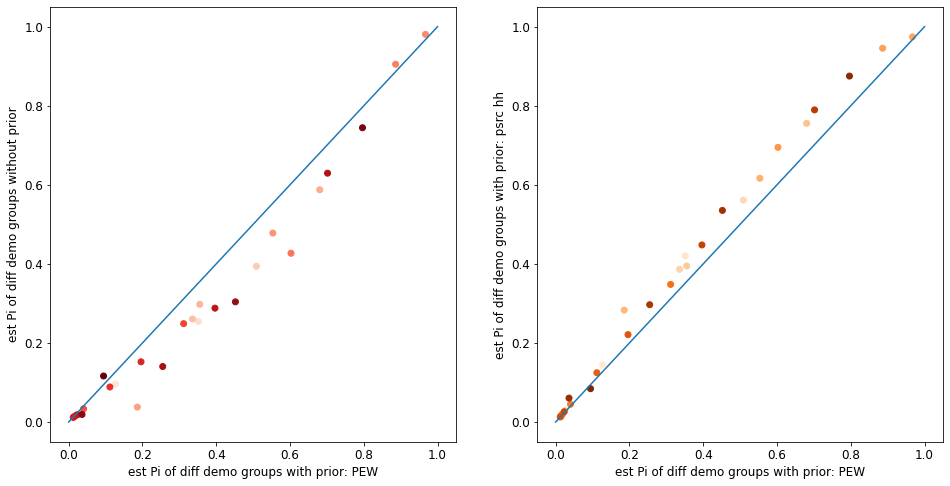

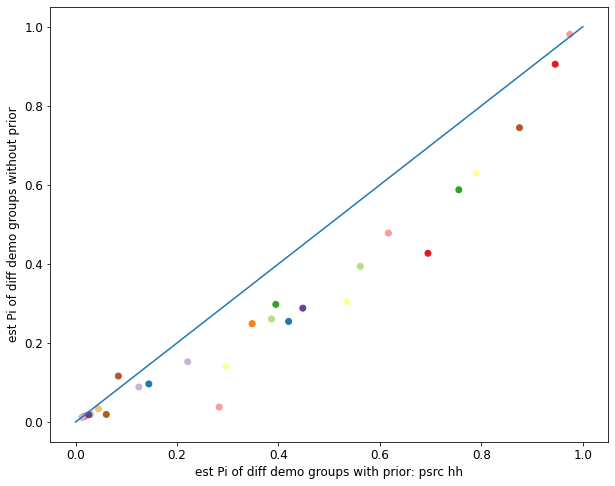

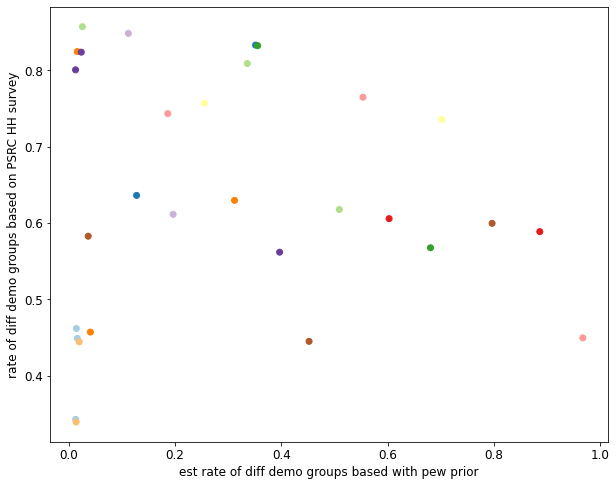

In [338]:
plt.rcParams["figure.figsize"] = (16,8)
x_val = list(range(0, 31))
fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1 = plt.subplot(121)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax1.scatter( fit_results_wp['mean'], fit_results_wop['mean'], c=x_val, cmap='Reds')
ax1.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax1.set_ylabel('est Pi of diff demo groups without prior')
ax1.set_xlabel('est Pi of diff demo groups with prior: PEW')

#x_val = list(range(0, 31))
#fig = plt.figure()
#ax2 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax2.scatter(fit_results_wp['mean'], fit_results_wphh['mean'], c=x_val, cmap='Oranges')
ax2.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax2.set_xlabel('est Pi of diff demo groups with prior: PEW')
ax2.set_ylabel('est Pi of diff demo groups with prior: psrc hh')


plt.rcParams["figure.figsize"] = (10,8)
x_val = list(range(0, 31))
fig = plt.figure()
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax3.scatter(fit_results_wphh['mean'], fit_results_wop['mean'], c=x_val, cmap='Paired')
ax3.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.set_ylabel('est Pi of diff demo groups without prior')
ax3.set_xlabel('est Pi of diff demo groups with prior: psrc hh')



x_val = list(range(0, 30))
fig = plt.figure()
ax4 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax4.scatter(fit_results_wp['mean'].values[:-1], psrc_hh_per, c=x_val, cmap='Paired')
#ax4.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax4.set_xlabel('est rate of diff demo groups based with pew prior')
ax4.set_ylabel('rate of diff demo groups based on PSRC HH survey')


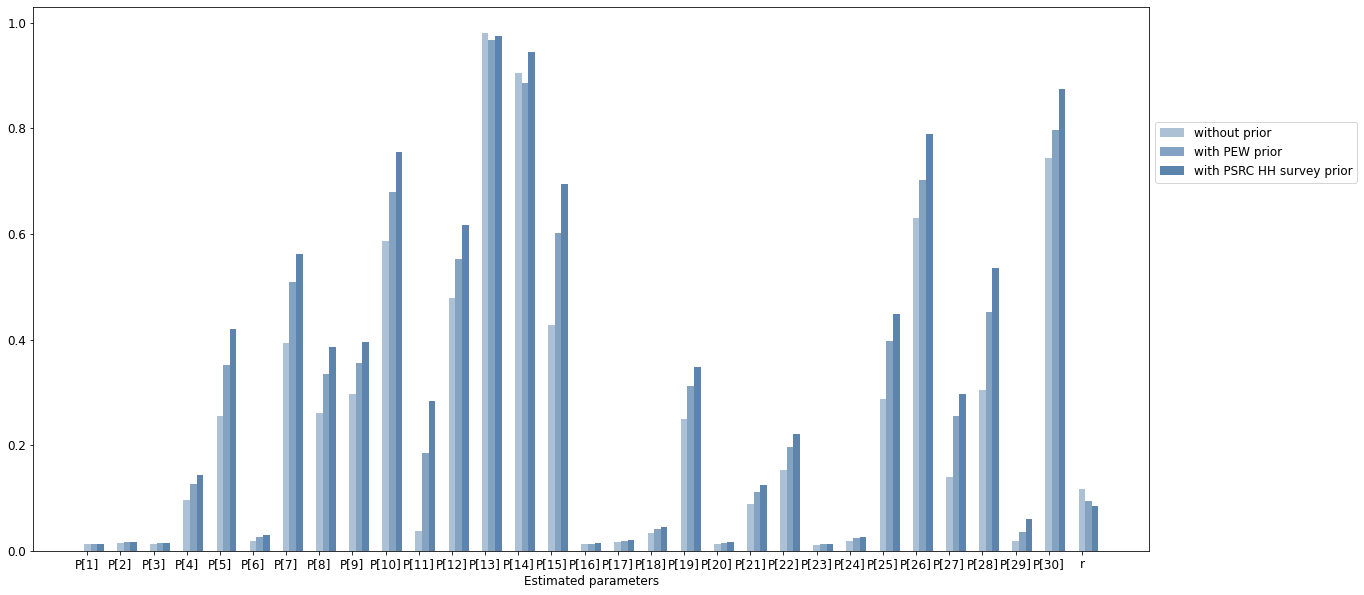

In [332]:
#color test
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 12})


x_val = list(range(1, 31))

N = fit_results_wop.shape[0]
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind,  fit_results_wop['mean'], 0.2, label='without prior', color=(0.2, 0.4, 0.6, 0.4))
bar2 = plt.bar(ind+width,  fit_results_wp['mean'], 0.2, label='with PEW prior', color=(0.2, 0.4, 0.6, 0.6))
bar3 = plt.bar(ind+width*2,  fit_results_wphh['mean'], 0.2, label='with PSRC HH survey prior', color=(0.2, 0.4, 0.6, 0.8))

plt.xlabel('Estimated parameters')
plt.xticks(np.arange(fit_results_wop.shape[0]), fit_results_wop['Unnamed: 0'].values)

plt.legend(bbox_to_anchor=(1, 0.8))

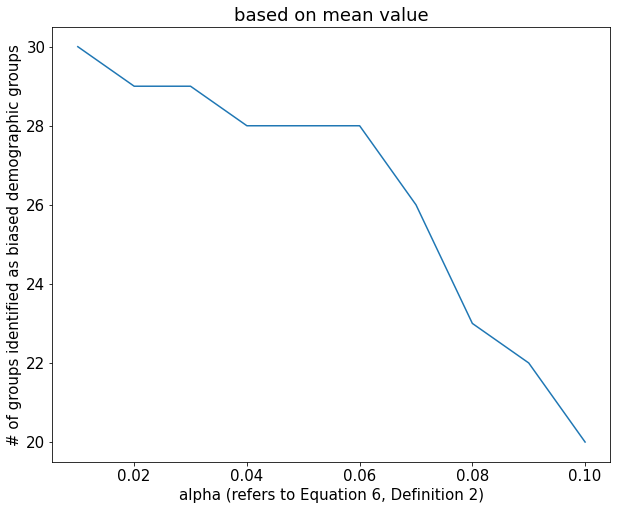

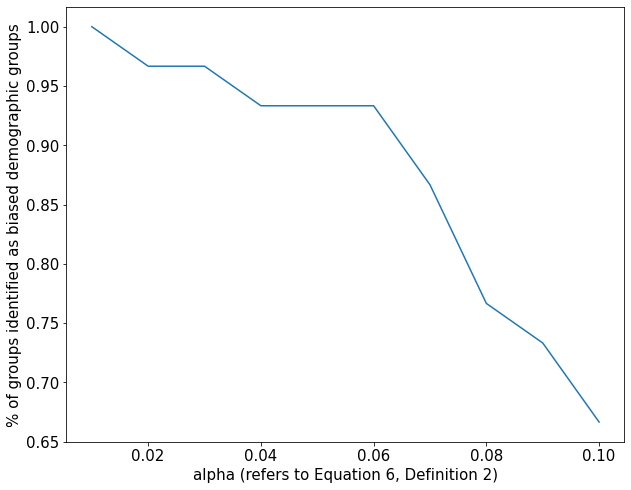

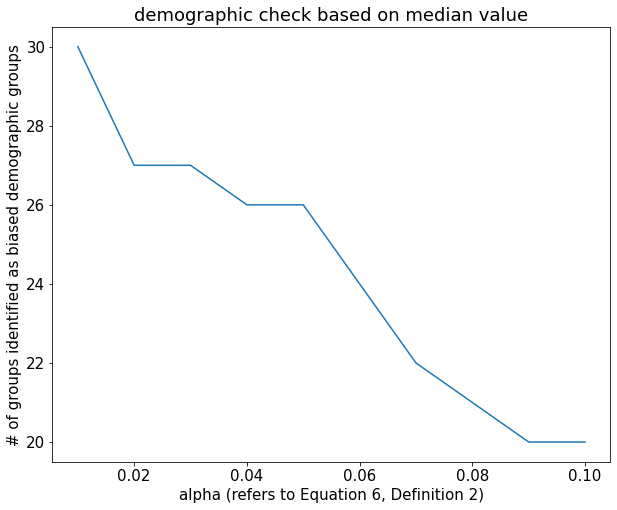

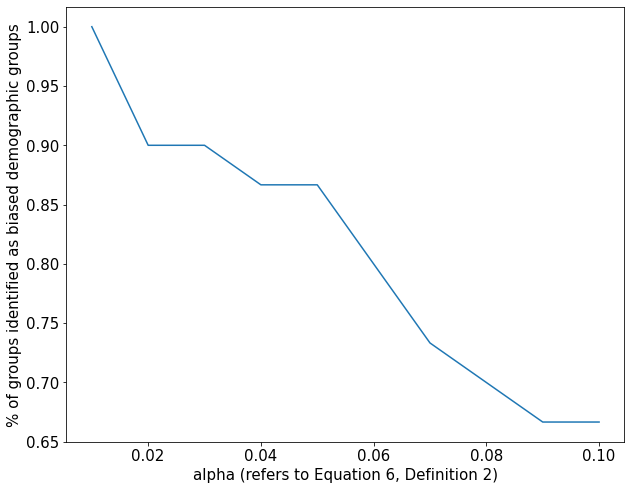

In [376]:
#bias check
def bias_check_plot(model_results):
    test_para = model_results['mean'].values[:-1]
    median_val = np.median(test_para)
    mean_val = np.mean(test_para)
    
    alpha_vals = np.arange(1, 11)*0.01
    mean_tests = []
    median_tests =[]
    Ng = len(test_para)
    for i in alpha_vals:
        median_tests.append(Ng-np.sum(np.abs(test_para-median_val)<=i))
        mean_tests.append(Ng-np.sum(np.abs(test_para-mean_val)<=i))
    mean_tests = np.array(mean_tests)
    median_tests = np.array(median_tests)
    
    plt.rcParams["figure.figsize"] = (10,8)
    plt.rcParams.update({'font.size': 15})
    plt.figure(0)
    plt.title('based on mean value')
    plt.plot(alpha_vals, mean_tests)
    plt.xlabel('alpha (refers to Equation 6, Definition 2)')
    plt.ylabel('# of groups identified as biased demographic groups')
    
    plt.figure(1)
    plt.plot(alpha_vals, mean_tests/Ng)
    plt.xlabel('alpha (refers to Equation 6, Definition 2)')
    plt.ylabel('% of groups identified as biased demographic groups')
    
    plt.figure(2)
    plt.title('demographic check based on median value')
    plt.plot(alpha_vals, median_tests)
    plt.xlabel('alpha (refers to Equation 6, Definition 2)')
    plt.ylabel('# of groups identified as biased demographic groups')
    
    plt.figure(3)
    plt.plot(alpha_vals, median_tests/Ng)
    plt.xlabel('alpha (refers to Equation 6, Definition 2)')
    plt.ylabel('% of groups identified as biased demographic groups')
    
fit_model_previous = pd.read_csv('model_all_wp_income.csv', nrows=31)
fit_model_previous.head(3)
bias_check_plot(fit_model_previous)

In [ ]:
demo_sim = pd.read_csv('')

In [377]:
taz_file = gpd.read_file('taz2010.shp')

In [381]:
#hh['hh_wt_final'] = hh["hh_wt_final"].replace(np.nan, 0)
conver_nan2zero = lambda x: 0 if type(x) == str else x

In [428]:
taz_file['num_appids'] = taz_file['num_appids'].replace(np.nan, 0)
taz_file['num_appids'] = taz_file['num_appids'].apply(conver_nan2zero)

In [439]:
np.nan in (taz_file['sim_basedonBI'])

False

In [410]:
#join app based data and simulated app based data for map plot
taz_file['num_appids'] = taz_file['num_appids'].replace(np.nan, 0)
taz_file['num_appids'] = taz_file['num_appids'].apply(conver_nan2zero)
#sim_per = list(fit_model_previous['mean'].values)
#sim_dt = assign_demo_num(person, 1)
#sim_dt = sim_dt[['id', 'demo_level', 'TAZ']]

#sim_dt['sim_basedonBI'] = sim_dt['demo_level'].apply(get_sim_basedonBI)

#get_sim_data(sim_dt, 'demo_level', 'sim_basedonBI', 'sim_dt_basedonBI_test_income.csv')

sim_dt = pd.read_csv('sim_dt_basedonBI_test_income.csv')
sim_dt = sim_dt[['TAZ ', 'sim_basedonBI']]
sim_dt.columns = ['TAZ', 'sim_basedonBI']
taz_file =  taz_file.join(sim_dt, lsuffix='TAZ', rsuffix='TAZ', how='left')

taz_file['sim_basedonBI'] = taz_file['sim_basedonBI'].replace(np.nan, 0)
taz_file['sim_basedonBI'] = taz_file['sim_basedonBI'].apply(conver_nan2zero)

taz_file.columns = ['TAZ1', 'COUNTY_FIP', 'COUNTY_NM', 'num_appids', 'geometry', 'TAZ2', 'sim_basedonBI']
taz_file = taz_file.drop(columns=['TAZ2'])

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\1158223603.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_dt['demo_level'] = (processed_dt['pgend']-1)*15 + \


data saved to csv, done


In [440]:
taz_file.to_file('psrc_map_data_app_data_compare.shp')

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\1206122886.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  taz_file.to_file('psrc_map_data_app_data_compare.shp')


In [471]:
taz_file = taz_file[(taz_file['sim_basedonBI']!=0) & (taz_file['num_appids']!=0)]

In [474]:
print(kstest(taz_file['num_appids'].values, taz_file['sim_basedonBI'].values))
print(mannwhitneyu(taz_file['num_appids'].values, taz_file['sim_basedonBI'].values))

KstestResult(statistic=0.015518913676042677, pvalue=0.850453655084685)
MannwhitneyuResult(statistic=4822579.5, pvalue=0.5761472484116656)


In [481]:
fit_model_p_psrchh['mean'].values[:-1]

array([0.44873347, 0.26781224, 0.09783921, 0.45217813, 0.6213886 ,
       0.82222602, 0.60670555, 0.57429281, 0.42382007, 0.57293114,
       0.79127461, 0.6518864 , 0.25363724, 0.96476269, 0.47970143,
       0.68495329, 0.74625771, 0.26321742, 0.98180982, 0.40223693,
       0.82150609, 0.23512878, 0.2300197 , 0.39022448, 0.43372638,
       0.50440579, 0.6035835 , 0.38040117, 0.18531157, 0.56152217])

array([0.37475121, 0.2210771 , 0.07528656, 0.34080318, 0.53790953,
       0.74923881, 0.5353453 , 0.51755256, 0.33549337, 0.51598978,
       0.71527667, 0.56935863, 0.18168292, 0.94675069, 0.35481049,
       0.59411001, 0.68672314, 0.23655719, 0.97481273, 0.32150656,
       0.76173653, 0.19342967, 0.16988904, 0.30891422, 0.37826058,
       0.40744979, 0.52223116, 0.33267904, 0.08573161, 0.45777877])

In [483]:
prior_pew = [0.3581475,0.3829250,0.4324800,0.6487200,0.6936000,
             0.7833600,0.6419625,0.6863750,0.7752000,0.5608725,
             0.5996750,0.6772800,0.4122075,0.4407250,0.4977600,
             0.3581475,0.3829250,0.4324800,0.6487200,0.6936000,
             0.7833600,0.6419625,0.6863750,0.7752000,0.5608725,
             0.5996750,0.6772800,0.4122075,0.4407250,0.4977600]
prior_psrc_hh = [0.3425791, 0.4519167, 0.4639026, 0.6360929, 0.8391084, 
                 0.8613635, 0.6176205, 0.8147403, 0.8363491, 0.5674873,
                 0.7486066, 0.7684614, 0.4494189, 0.5928555, 0.6085794, 
                 0.3390872, 0.4473104, 0.4591741, 0.6296093, 0.8305554, 
                 0.8525837, 0.6113251, 0.8064357, 0.8278242, 0.561703, 
                 0.7409762, 0.7606285, 0.444838, 0.5868126, 0.6023762]
est_pew = fit_model_previous['mean'].values[:-1]
est_psrc_hh = fit_model_p_psrchh['mean'].values[:-1]

array(['P[1]', 'P[2]', 'P[3]', 'P[4]', 'P[5]', 'P[6]', 'P[7]', 'P[8]',
       'P[9]', 'P[10]', 'P[11]', 'P[12]', 'P[13]', 'P[14]', 'P[15]',
       'P[16]', 'P[17]', 'P[18]', 'P[19]', 'P[20]', 'P[21]', 'P[22]',
       'P[23]', 'P[24]', 'P[25]', 'P[26]', 'P[27]', 'P[28]', 'P[29]',
       'P[30]'], dtype=object)

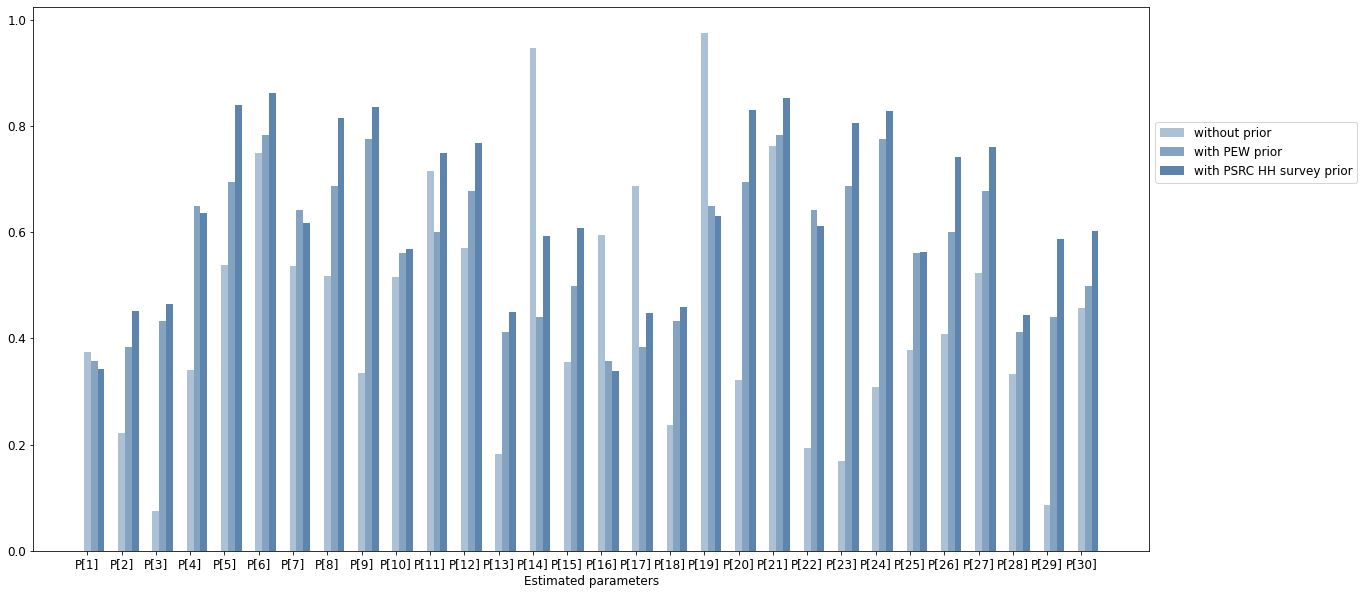

In [489]:
#color test
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 12})


x_val = list(range(1, 30))

N = est_pew.shape[0]
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind,  est_pew, 0.2, label='without prior', color=(0.2, 0.4, 0.6, 0.4))
bar2 = plt.bar(ind+width,  prior_pew, 0.2, label='with PEW prior', color=(0.2, 0.4, 0.6, 0.6))
bar3 = plt.bar(ind+width*2,  prior_psrc_hh, 0.2, label='with PSRC HH survey prior', color=(0.2, 0.4, 0.6, 0.8))

plt.xlabel('Estimated parameters')
plt.xticks(np.arange(fit_results_wop.shape[0]-1),fit_results_wop['Unnamed: 0'].values[:-1])

plt.legend(bbox_to_anchor=(1, 0.8))

In [497]:
print(kstest(est_pew, prior_psrc_hh))
print(mannwhitneyu(est_pew, prior_psrc_hh))

KstestResult(statistic=0.4666666666666667, pvalue=0.0025300622362698397)
MannwhitneyuResult(statistic=214.0, pvalue=0.0004981816723342355)


In [ ]:
xtick

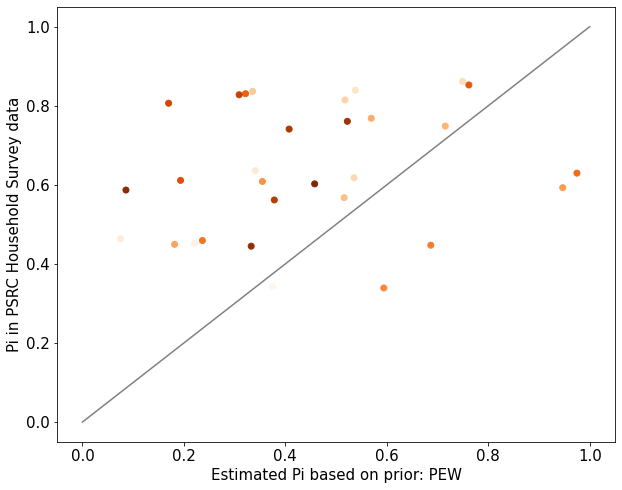

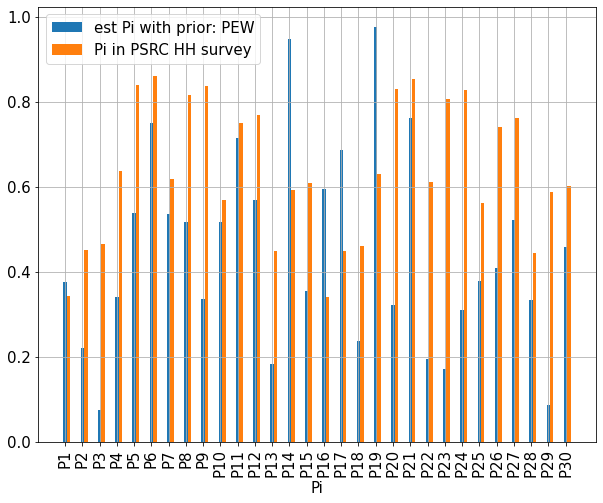

In [522]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})
x_val = list(range(0, 31))
fig = plt.figure(1)
ax3 = plt.subplot(111)

plt.scatter(est_pew, prior_psrc_hh, c=np.arange(30),  cmap='Oranges')
plt.plot([0,1], [0,1], 'grey')
plt.xlabel('Estimated Pi based on prior: PEW')
plt.ylabel('Pi in PSRC Household Survey data')


plt.figure(2)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})
x_val = list(range(1, 31))
N = fit_model_previous.shape[0]-1
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind, est_pew, 0.2, label='est Pi with prior: PEW')
bar2 = plt.bar(ind+width, prior_psrc_hh, 0.2, label='Pi in PSRC HH survey')

plt.xlabel('Pi')
plt.xticks(np.arange(fit_results_wop.shape[0]-1), xtick_val[:-1], rotation=90)
plt.grid()

plt.legend(loc='upper left')

In [392]:
sim_appdt.columns

Index(['TAZ', 'demo_level_1', 'demo_level_2', 'demo_level_3', 'demo_level_4',
       'demo_level_5', 'demo_level_6', 'demo_level_7', 'demo_level_8',
       'demo_level_9', 'demo_level_10', 'demo_level_11', 'demo_level_12',
       'demo_level_13', 'demo_level_14', 'demo_level_15', 'demo_level_16',
       'demo_level_17', 'demo_level_18', 'demo_level_19', 'demo_level_20',
       'demo_level_21', 'demo_level_22', 'demo_level_23', 'demo_level_24',
       'demo_level_25', 'demo_level_26', 'demo_level_27', 'demo_level_28',
       'demo_level_29', 'demo_level_30', 'app_count'],
      dtype='object')

In [390]:
sim_appdt[['TAZ', 'app_count']]

,TAZ,app_count
0,1,17
1,2,30
2,3,66
3,4,38
4,5,28
...,...,...
3438,3696,72
3439,3697,200
3440,3698,118
3441,3699,55


In [337]:
print(kstest(sim_per, fit_results_sim_wp['mean']))
print(kstest(sim_per, fit_results_sim_wsimp['mean']))
print(mannwhitneyu(sim_per, fit_results_sim_wp['mean']))
print(mannwhitneyu(sim_per, fit_results_sim_wsimp['mean']))

KstestResult(statistic=0.3225806451612903, pvalue=0.07912044264087828)
KstestResult(statistic=0.25806451612903225, pvalue=0.2560450207654439)
MannwhitneyuResult(statistic=315.0, pvalue=0.020174767073543952)
MannwhitneyuResult(statistic=443.0, pvalue=0.6024039863747686)


Text(0, 0.5, 'rate of diff demo groups based on PSRC HH survey')

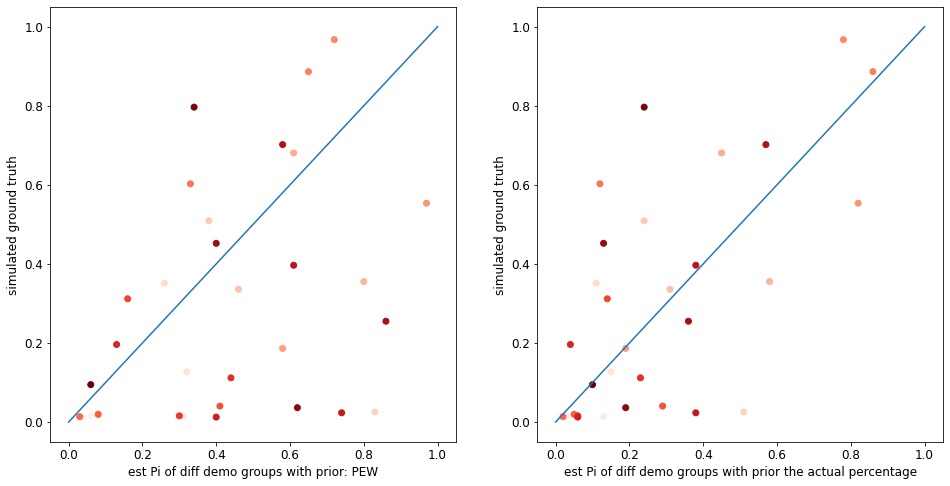

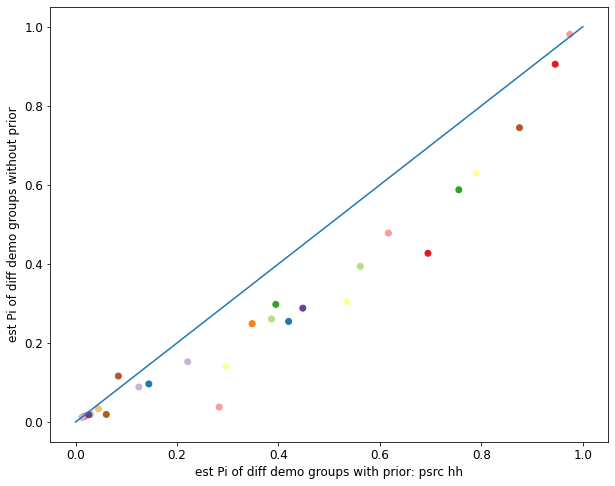

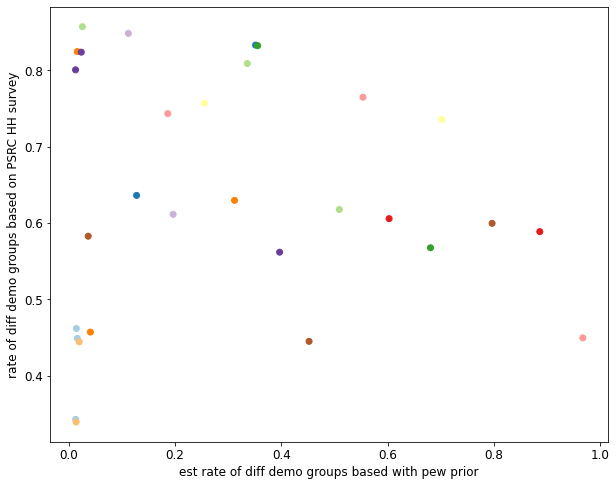

In [334]:
plt.rcParams["figure.figsize"] = (16,8)
x_val = list(range(0, 31))
fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1 = plt.subplot(121)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax1.scatter(fit_results_sim_wp['mean'], sim_per, c=x_val, cmap='Reds')
ax1.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax1.set_ylabel('simulated ground truth')
ax1.set_xlabel('est Pi of diff demo groups with prior: PEW')

#x_val = list(range(0, 31))
#fig = plt.figure()
#ax2 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax2.scatter(fit_results_sim_wsimp['mean'], sim_per, c=x_val, cmap='Reds')
ax2.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax2.set_ylabel('simulated ground truth')
ax2.set_xlabel('est Pi of diff demo groups with prior the actual percentage')


plt.rcParams["figure.figsize"] = (10,8)
x_val = list(range(0, 31))
fig = plt.figure()
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax3.scatter(fit_results_wphh['mean'], fit_results_wop['mean'], c=x_val, cmap='Paired')
ax3.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.set_ylabel('est Pi of diff demo groups without prior')
ax3.set_xlabel('est Pi of diff demo groups with prior: psrc hh')



x_val = list(range(0, 30))
fig = plt.figure()
ax4 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax4.scatter(fit_results_wp['mean'].values[:-1], psrc_hh_per, c=x_val, cmap='Paired')
#ax4.plot([0, 1], [0,1])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax4.set_xlabel('est rate of diff demo groups based with pew prior')
ax4.set_ylabel('rate of diff demo groups based on PSRC HH survey')

In [315]:
sim_per
fit_results_sim_wp = pd.read_csv('model_sim_all_BI_wp.csv')
fit_results_sim_wsimp = pd.read_csv('model_sim_all_BI_wsimp.csv')

In [319]:
len(fit_results_sim_wp['mean'].values[:-1])

30

In [322]:
len(sim_per)

31

In [512]:
xtick_val = []
for i in range(1, N+2):
    if i!=N+1:
        xtick_val.append('P'+str(i))
    else:
        xtick_val.append('r')

In [513]:
xtick_val

['P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'r']

In [ ]:
#sim tests

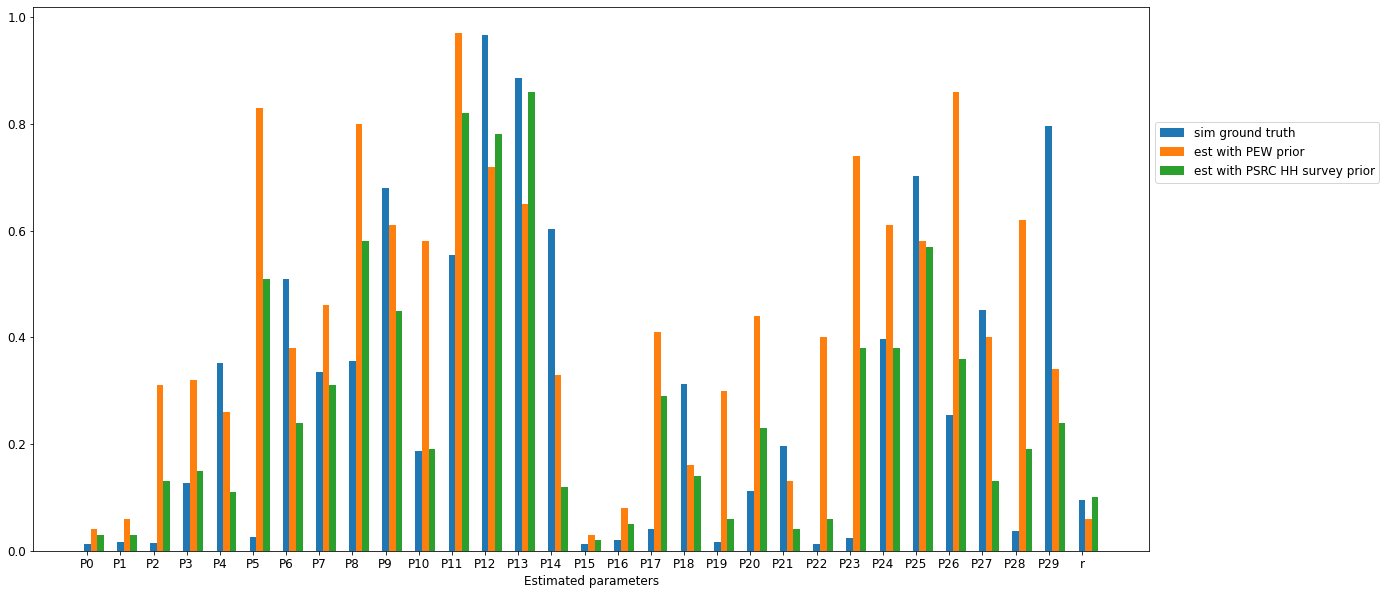

In [331]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 12})

x_val = list(range(1, 31))

N = fit_results_wop.shape[0]
ind = np.arange(N)
width=.2

bar1 = plt.bar(ind,  sim_per, 0.2, label='sim ground truth') #, color=(0.2, 0.6, 0.6, 0.4)
bar2 = plt.bar(ind+width,  fit_results_sim_wp['mean'], 0.2, label='est with PEW prior') # , color=(0.2, 0.4, 0.6, 0.6))
bar3 = plt.bar(ind+width*2,  fit_results_sim_wsimp['mean'], 0.2, label='est with PSRC HH survey prior') #color=(0.2, 0.4, 0.6, 0.8)

plt.xlabel('Estimated parameters')
plt.xticks(np.arange(fit_results_wop.shape[0]), xtick_val)

plt.legend(bbox_to_anchor=(1, 0.8))

array([0.01273159, 0.01588305, 0.01401097, 0.12739396, 0.35138252,
       0.02538489, 0.50892893, 0.33580491, 0.35525688, 0.68054185,
       0.18613867, 0.55349754, 0.96729152, 0.88628823, 0.60265807,
       0.01355176, 0.01948694, 0.04036529, 0.31171939, 0.01568323,
       0.11180567, 0.19615292, 0.01251367, 0.02333293, 0.39660124,
       0.70176048, 0.25501026, 0.45204837, 0.03628677, 0.79649342])

In [215]:
from sklearn.metrics import mean_squared_error
a = mean_squared_error(np.ones(fit_results_wop['Rhat'].shape), fit_results_wop['Rhat'])
b = mean_squared_error(np.ones(fit_results_wop['Rhat'].shape), fit_results_wp['Rhat'])
c = mean_squared_error(np.ones(fit_results_wop['Rhat'].shape), fit_results_wphh['Rhat'])
print(a, b, c)
min(a, b, c)

8.314314957389102e-08 4.8312141363952645e-08 2.70451929682798e-08


2.70451929682798e-08

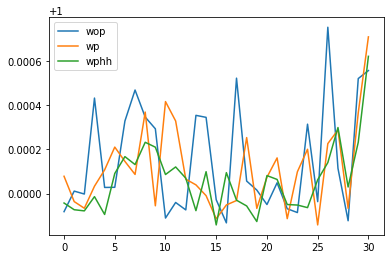

In [150]:
#check rhat
plt.plot(fit_results_wop['Rhat'], label='wop')
plt.plot(fit_results_wp['Rhat'], label='wp')
plt.plot(fit_results_wphh['Rhat'], label='wphh')
plt.legend()

In [48]:
test_dt = save_dtforest(person, num_home_taz, 'demo_group_dt_psrc_nogen.csv', 4, True, True)
test_dt.columns

C:\Users\29700\AppData\Local\Temp\ipykernel_22916\1158223603.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_dt['demo_level'] = (processed_dt['deage'])*3 +\


Index(['TAZ', 'demo_level_1', 'demo_level_2', 'demo_level_3', 'demo_level_4',
       'demo_level_5', 'demo_level_6', 'demo_level_7', 'demo_level_8',
       'demo_level_9', 'demo_level_10', 'demo_level_11', 'demo_level_12',
       'demo_level_13', 'demo_level_14', 'demo_level_15', 'app_count'],
      dtype='object')

In [47]:
test_dt.head(3)

,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,demo_level_10,demo_level_11,demo_level_12,demo_level_13,demo_level_14,demo_level_15,app_count
0,1,2,11,174,0,1,45,6,5,207,7,26,262,19,14,201,17
1,2,51,39,241,38,31,95,97,102,420,130,33,168,134,64,77,30
2,3,69,4,69,162,48,376,340,90,282,306,63,138,511,117,116,66


In [ ]:
#save_dtforest(person_crossed, app_based_count, 'demo_group_dt.csv', return_index=False)
#save_dtforest(person_crossed, app_based_count, 'demo_group_dt_fullinocme.csv', simplify_income=False, return_index=False)

### Check if data can be clustered

In [183]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018/')

In [185]:
#from kneed import KneeLocator
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import jenkspy

In [9]:
#help(jenkspy.jenks_breaks)
demo_group_dt = pd.read_csv('demo_group_dt.csv', index_col=0)
print(len(demo_group_dt))
demo_group_dt['ct_over_sum'] = (demo_group_dt['appid_count'])/(demo_group_dt['psrc_sum'])
print(demo_group_dt.head(3))

3424
   TAZ  demo_level_1  demo_level_2  demo_level_3  demo_level_4  demo_level_5  \
0    1             2            96            15             0            16   
1    2            38           165             2            19            61   
2    3            39            46             0            82           155   

   demo_level_6  demo_level_7  demo_level_8  demo_level_9  ...  demo_level_29  \
0             0             3            94            19  ...            106   
1             4            32           206            19  ...             78   
2             0            99           183             2  ...            107   

   demo_level_30  appid_count  COUNTY_FIP  COUNTY_NM         Area  \
0              3           17          33       King  7117998.770   
1              0           30          33       King   488714.265   
2              0           66          33       King   503192.772   

                                            geometry  TAZ1  psrc_sum  \


In [278]:
#data processing, delete rate > 1
demo_group_dt = demo_group_dt.sort_values(by=['ct_over_sum'])
demo_group_dt = demo_group_dt[demo_group_dt['ct_over_sum']<=1]
len(demo_group_dt)

3385

In [292]:
#delete the count is only 1 and the % is smaller than 5%
del_TAZs = demo_group_dt[['TAZ']][(demo_group_dt['ct_over_sum']<0.01) &
                             (demo_group_dt['appid_count']<=5)]
del_TAZs = del_TAZs.values.T[0]
demo_group_dt = demo_group_dt[~demo_group_dt['TAZ'].isin(del_TAZs)]

,TAZ
582,627
602,659
1735,1895
1919,2081


[ 627  659 1895 1655  216  120  472 2691  614  496 1259  661 2253 2182
  112 3392  378 2081 1747 2861 2831 1388  885 1758]


In [299]:
for i in range(2, 6):
    print('num class='+str(i), jenkspy.jenks_breaks(demo_group_dt_test['ct_over_sum'],
                               n_classes=i))

num class=2 [0.0025974025974025974, 0.031818181818181815, 0.07954545454545454]
num class=3 [0.0025974025974025974, 0.025466893039049237, 0.041189931350114416, 0.07954545454545454]
num class=4 [0.0025974025974025974, 0.02226027397260274, 0.032359081419624215, 0.05, 0.07954545454545454]
num class=5 [0.0025974025974025974, 0.02027027027027027, 0.027941176470588237, 0.03687315634218289, 0.053036126056879324, 0.07954545454545454]


In [302]:
#get natural breaks
#source: https://stackoverflow.com/questions/11513484/1d-number-array-clustering
#source: https://pbpython.com/natural-breaks.html
def get_labels(class_num):
    labels = []
    for i in range(class_num):
        labels.append('c'+str(i+1))
    return(labels)

class_num = 2
demo_group_dt['rate_cut_jenk'] = pd.cut(
    demo_group_dt['ct_over_sum'],
    bins=jenkspy.jenks_breaks(demo_group_dt['ct_over_sum'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

demo_group_dt.groupby(by=['rate_cut_jenk']).size()

rate_cut_jenk
c1    3335
c2      26
dtype: int64

In [304]:
demo_group_dt = demo_group_dt[demo_group_dt['rate_cut_jenk']=='c1']

### Revised the data and check the data rate
the reason to check the data is that we found number of app-based id (estimated with home location) is larger than the PSRC simulation population at some TAZ

#### delete part of the TAZ

In [68]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')
demo_group_dt = pd.read_csv('demo_group_dt.csv', index_col=0)

#check the rate
colname = list(demo_group_dt.columns)
demo_group_dt['sumup_psrc_demo'] = np.sum(demo_group_dt[colname[1:31]], axis=1)
demo_group_dt['sum_demo_rate'] = demo_group_dt['appid_count']/demo_group_dt['sumup_psrc_demo']

demo_group_dt[['TAZ', 'sum_demo_rate']][demo_group_dt['sum_demo_rate']>0.1].sort_values(by=['sum_demo_rate'], ascending=False).head(3)

,TAZ,sum_demo_rate
886,983,41.6
1049,1167,29.0
2866,3124,19.5


In [69]:
#demo_group_dt[['TAZ','sum_demo_rate']][demo_group_dt['sum_demo_rate']>0.08].sort_values(by=['sum_demo_rate'], ascending=False)
#through checking the data
#it is found that all the rate which is larger than 0.1 mostly located at the working area,
#the most highest rate (the top 2) all locates at the airport
#thus we kept all the rate <0.08 as most of the areas are found locate in the residential area

demo_group_dt = demo_group_dt[demo_group_dt['sum_demo_rate']<0.08]

#tide dt shape
#(3424, 40)

#revised dt shape
#(3267, 40)

#about 4% of the tide dt are deleted

demo_group_dt['sum_demo_rate'].describe()

count    3267.000000
mean        0.027207
std         0.009923
min         0.002597
25%         0.021143
50%         0.025837
75%         0.031445
max         0.078571
Name: sum_demo_rate, dtype: float64

In [ ]:
demo_group_dt.to_csv('demo_group_dt_revised.csv')

#### Revise the demographic group

In [377]:
#delete the geneder parameter
demo_group_dt.head(3)
demo_col = demo_group_dt.columns[1:31]
#Based on the demographic number defination
#if we would like to ignore the gender, we can sum up the demo_group_1 and demo_group_16 as demo_new_group1 
#since they are female and male group with the same age and income level
gender_interval = 15
for i in range(gender_interval):
    demos = demo_col[i].split('_')
    demo_new_col = demos[0]+demos[2]
    demo_group_dt[demo_new_col] = demo_group_dt[demo_col[i]]+demo_group_dt[demo_col[i+gender_interval]]

C:\Users\29700\AppData\Local\Temp\ipykernel_5408\1418746027.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_group_dt[demo_new_col] = demo_group_dt[demo_col[i]]+demo_group_dt[demo_col[i+gender_interval]]


In [309]:
demo_group_dt.drop(columns=demo_col).to_csv('demo_group_dt_revised_no_gender_cut.csv')

In [310]:
exclude_group

['demo_level_7',
 'demo_level_8',
 'demo_level_9',
 'demo_level_10',
 'demo_level_11',
 'demo_level_12',
 'demo_level_22',
 'demo_level_23',
 'demo_level_24']

In [379]:
demo_group_dt.columns

Index([         'TAZ', 'demo_level_1', 'demo_level_2', 'demo_level_3',
       'demo_level_4', 'demo_level_5', 'demo_level_6', 'demo_level_7',
       'demo_level_8', 'demo_level_9',
       ...
              'demo6',        'demo7',        'demo8',        'demo9',
             'demo10',       'demo11',       'demo12',       'demo13',
             'demo14',       'demo15'],
      dtype='object', length=119)

In [380]:
#squeeze the age into four levels
#previous level
#<18, 18-29, 30-49, 50-64, >65
#current level (since the smartphone ownership shows similar % in the group 18-29 and 30-49)
#<18, 18-49, 50-64, >65
dt_colname = demo_group_dt.columns
demo_group_dt_revisedage = demo_group_dt[['TAZ','COUNTY_NM', 'Area','psrc_sum','appid_count']]
revised_age_group = ['demo_level_4', 'demo_level_5', 'demo_level_6', 'demo_level_7', 'demo_level_8', 'demo_level_9',
                    'demo_level_19', 'demo_level_20','demo_level_21', 'demo_level_22', 'demo_level_23', 'demo_level_24']

exclude_group = []
for i in range(len(revised_age_group)-3):
    num = int(revised_age_group[i].split('_')[-1])
    exclude_group.append('demo_level_'+str(num+3))
    if revised_age_group[i] not in exclude_group:
        demo_group_dt_revisedage[revised_age_group[i]] = demo_group_dt['demo_level_'+str(num)]+demo_group_dt['demo_level_'+str(num+3)]        

C:\Users\29700\AppData\Local\Temp\ipykernel_5408\200866601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_group_dt_revisedage[revised_age_group[i]] = demo_group_dt['demo_level_'+str(num)]+demo_group_dt['demo_level_'+str(num+3)]


In [381]:
#revised_num = [4,5,6,7,8,9,19,20,21,22,23,24]
demo_group_dt_revisedage.columns = ['TAZ','COUNTY_NM', 'Area','psrc_sum','appid_count', 'demo_level_4', 'demo_level_5',
                                    'demo_level_6', 'demo_level_16', 'demo_level_17', 'demo_level_18']
demo_group_dt_revisedage[['demo_level_1', 'demo_level_2','demo_level_3']] = demo_group_dt[['demo_level_1', 'demo_level_2','demo_level_3']]
demo_group_dt_revisedage[['demo_level_7', 'demo_level_8','demo_level_9',
                         'demo_level_10', 'demo_level_11','demo_level_12',
                         'demo_level_13', 'demo_level_14','demo_level_15']] = demo_group_dt[['demo_level_10', 'demo_level_11','demo_level_12',
                                                                                            'demo_level_13', 'demo_level_14','demo_level_15',
                                                                                            'demo_level_16', 'demo_level_17','demo_level_18']]
demo_group_dt_revisedage[['demo_level_19', 'demo_level_20','demo_level_21',
                         'demo_level_22', 'demo_level_23','demo_level_24']] = demo_group_dt[['demo_level_25', 'demo_level_26','demo_level_27',
                                                                                            'demo_level_28', 'demo_level_29','demo_level_30']]     

C:\Users\29700\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [384]:
demo_group_dt_revisedage.columns=[98, 99, 100, 101, 102, 4, 5, 6, 16, 17, 18, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 
                                  20, 21, 22, 23, 24]
demo_group_dt_revisedage = demo_group_dt_revisedage.sort_index(ascending = True, axis = 1)
demo_group_dt_revisedage.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                   18, 19, 20, 21, 22, 23, 24, 'TAZ','COUNTY_NM', 'Area','psrc_sum','appid_count']

In [385]:
demo_group_dt_revisedage.head(3)

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,TAZ,COUNTY_NM,Area,psrc_sum,appid_count
0,2,96,15,3,110,19,10,124,14,9,...,122,18,14,106,3,1,King,7117998.770,980,17
1,38,165,2,51,267,23,56,76,4,40,...,109,6,105,78,0,2,King,488714.265,1720,30
2,39,46,0,181,338,2,160,65,1,131,...,117,1,405,107,0,3,King,503192.772,2699,66


In [386]:
#rerun the demo group process based on the land use home
for i in range(24):
    demo_group_dt['demo_age_'+str(i+1)] = demo_group_dt_revisedage[i+1]
demo_group_dt.to_csv('demo_group_dt_land_.csv')

C:\Users\29700\AppData\Local\Temp\ipykernel_5408\3019540070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_group_dt['demo_age_'+str(i+1)] = demo_group_dt_revisedage[i+1]


In [318]:
demo_group_dt_revisedage.to_csv('demo_group_dt_revised_age_cut.csv')

In [391]:
demo_group_dt.shape

(2889, 143)

## Add land use info
* [data source](https://github.com/psrc/soundcast/releases/tag/v3.0.1_RTP)
* [data info](https://github.com/psrc/soundcast/wiki/lutype_lookup)
* [land use info](https://github.com/psrc/soundcast/wiki/Inputs#land-use)

In [ ]:
import csv

In [210]:
os.chdir("G:/My Drive/2021/Bias/PSRC_od_simulation_2018/")

demo_group_dt = pd.read_csv('demo_group_dt.csv', index_col=0)
demo_group_dt.head(3)

#check the rate
colname = list(demo_group_dt.columns)
demo_group_dt['sumup_psrc_demo'] = np.sum(demo_group_dt[colname[1:31]], axis=1)
demo_group_dt['sum_demo_rate'] = demo_group_dt['appid_count']/demo_group_dt['sumup_psrc_demo']

#demo_group_dt[['TAZ', 'sum_demo_rate']][demo_group_dt['sum_demo_rate']>0.1].sort_values(by=['sum_demo_rate'], ascending=False).head(3)


In [30]:
land_use = pd.read_csv('v3.0.0_2018_2050/landuse/2018/v3.0_RTP/parcels_urbansim.txt',
                      sep=" ")

In [419]:
#land_use['lutype_p'].describe()
#lutype_p --> NA

In [218]:
#check the data format
print(len(np.unique(demo_group_dt['TAZ'])))
print(demo_group_dt.shape)
print(land_use.shape)

3424
(3424, 40)
(1302434, 29)


In [396]:
np.unique(land_use['lutype_p'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [219]:
#land use var processing
land_use_describe = land_use[['taz_p', 'lutype_p']].groupby(['taz_p','lutype_p']).size().unstack(fill_value=0)
land_use_describe.reset_index(inplace=True)

#other var processing (all related number of people ...)
land_use_sum = land_use.drop(columns=['lutype_p','parcelid','xcoord_p', 'ycoord_p','ppricdyp', 'pprichrp']).groupby(['taz_p']).sum()
land_use_sum.reset_index(inplace=True)
#land_use_sum.drop()

#price var processing
land_use_p = land_use[['taz_p', 'ppricdyp', 'pprichrp']].groupby('taz_p').mean()
land_use_p.reset_index(inplace=True)

#only focus on the land use var with max val
land_use_var = land_use[['taz_p', 'lutype_p']].groupby(['taz_p','lutype_p']).size().to_frame()
land_use_var.reset_index(inplace=True)
land_use_var.columns = ['taz_p', 'lutype_p', 'count']
idx = land_use_var.groupby('taz_p')['count'].transform(max) == land_use_var['count']
land_use_var = land_use_var[idx]

In [220]:
demo_group_dt = pd.merge(demo_group_dt, land_use_describe, left_on="TAZ", 
                        right_on="taz_p", how='left')
demo_group_dt = pd.merge(demo_group_dt, land_use_sum, left_on="TAZ", 
                        right_on="taz_p", how='left')
demo_group_dt = pd.merge(demo_group_dt, land_use_p, left_on="TAZ", 
                        right_on="taz_p", how='left')
del(land_use_describe)
del(land_use_sum)
del(land_use_p)

In [236]:
land_var_check = land_use_var.groupby(['taz_p']).size().to_frame()
land_var_check.reset_index(inplace=True)
vartazlarger2 = np.unique(land_var_check[['taz_p']][land_var_check[0]>1])
land_use_var[land_use_var['taz_p'].isin(vartazlarger2)]
del(land_var_check)

,taz_p,lutype_p,count
845,105,7,5
846,105,14,5
2076,290,2,1
2077,290,30,1
2145,301,23,3
...,...,...,...
28825,3355,19,1
31032,3530,3,11
31040,3530,26,11
31984,3623,3,35


In [274]:
home_index = [13, 14, 15, 24]
demo_group_dt['land_use_h_sum'] = np.sum(demo_group_dt[home_index].values, axis=1)

In [275]:
demo_group_dt

,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,demo_level_9,...,sqft_p,stugrd_p,stuhgh_p,stuuni_p,taz_p_x,ppricdyp,pprichrp,taz_p_y,lutype_p,land_use_h_sum
0,1,2,96,15,0,16,0,3,94,19,...,11638290,0,0,0,1,0.0,0.0,1,24,391
1,2,38,165,2,19,61,4,32,206,19,...,3948357,0,0,0,2,0.0,0.0,2,24,392
2,3,39,46,0,82,155,0,99,183,2,...,3914003,0,0,0,3,0.0,0.0,3,24,271
3,4,29,20,0,89,102,0,85,114,3,...,3153505,503,0,0,4,0.0,0.0,4,24,90
4,5,17,40,3,21,78,1,16,94,4,...,1709457,0,0,0,5,0.0,0.0,5,24,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,3696,15,115,11,17,18,1,6,95,0,...,22558815,41,0,0,3696,0.0,0.0,3696,24,329
3477,3697,27,120,14,12,33,1,15,135,0,...,40954997,0,0,0,3697,0.0,0.0,3697,24,632
3478,3698,23,69,5,8,15,0,7,68,0,...,13046357,90,0,0,3698,0.0,0.0,3698,24,296
3479,3699,14,160,17,8,100,0,9,155,0,...,51501063,326,0,0,3699,0.0,0.0,3699,24,659


In [237]:
demo_group_dt = pd.merge(demo_group_dt, land_use_var[['taz_p','lutype_p']],
                         left_on="TAZ", 
                        right_on="taz_p", how='left')
#land_use_var.groupby(['lutype_p']).size().to_frame()

In [92]:
demo_group_dt.to_csv('demo_group_dt_landuse.csv')

In [121]:
#select the location which mainly focused on residential
demo_group_dt[(demo_group_dt['lutype_p'].isin([8, 13, 14, 15, 24]))&(
    demo_group_dt['sum_demo_rate']<=0.1)].to_csv('demo_group_dt_landuse_revised.csv')

In [178]:
#demo_group_dt.columns

In [159]:
from scipy.stats import kstest
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [161]:
def get_test_result(test_func, dt1, dt2):
    stats, p_val = test_func(dt1, dt2)
    return(stats, p_val)

In [187]:
scaler = StandardScaler()
for i in range(31):
    if i != 16:
        scaling_dt = scaler.fit_transform(demo_group_dt[['appid_count', i]])
        dt1 = scaling_dt.T[0]
        dt2 = scaling_dt.T[1]
        
        ks_stats, ks_p = get_test_result(kstest, dt1, dt2)
        wilcoxon_stats, wilcoxon_p = get_test_result(wilcoxon, dt1, dt2)
        mannwhitneyu_stats, mannwhitneyu_p = get_test_result(mannwhitneyu, dt1, dt2)
        
        p_val = [ks_p, wilcoxon_p, mannwhitneyu_p]
        
        stats_label = ['kstest', 'wilconx', 'mannwhitneyu']
        for j in range(len(p_val)):
            if p_val[j] > 0.05:
                print(p_val[j])
                print('stats distribution is similar '+stats_label[j]+
                      'with land use var'+str(i))

##seems no land use var shows statistically similar         

0.1570836224759502
stats distribution is similar wilconxwith land use var2
0.39339547827612753
stats distribution is similar wilconxwith land use var3
0.21320559341901058
stats distribution is similar wilconxwith land use var10
0.06668307549530461
stats distribution is similar wilconxwith land use var14
0.12752582273147847
stats distribution is similar mannwhitneyuwith land use var14
0.7763166290396541
stats distribution is similar wilconxwith land use var18
0.22342045002509825
stats distribution is similar wilconxwith land use var20
0.16688250323215315
stats distribution is similar wilconxwith land use var21
0.16722435066482866
stats distribution is similar wilconxwith land use var22
0.6469783072992763
stats distribution is similar mannwhitneyuwith land use var24
0.7579379821193744
stats distribution is similar wilconxwith land use var28
0.18530543755670903
stats distribution is similar wilconxwith land use var30


In [277]:
scaling_dt = scaler.fit_transform(demo_group_dt[['appid_count', 'psrc_sum']])
dt1 = scaling_dt.T[0]
dt2 = scaling_dt.T[1]

ks_stats, ks_p = get_test_result(kstest, dt1, dt2)
wilcoxon_stats, wilcoxon_p = get_test_result(wilcoxon, dt1, dt2)
mannwhitneyu_stats, mannwhitneyu_p = get_test_result(mannwhitneyu, dt1, dt2)

p_val = [ks_p, wilcoxon_p, mannwhitneyu_p]

stats_label = ['kstest', 'wilconx', 'mannwhitneyu']
for j in range(len(p_val)):
    if p_val[j] > 0.05:
        print(p_val[j])
        print('stats distribution is similar '+stats_label[j]+' psrc_sum')
        
scaling_dt = scaler.fit_transform(demo_group_dt[['appid_count', 'land_use_h_sum']])
dt1 = scaling_dt.T[0]
dt2 = scaling_dt.T[1]

ks_stats, ks_p = get_test_result(kstest, dt1, dt2)
wilcoxon_stats, wilcoxon_p = get_test_result(wilcoxon, dt1, dt2)
mannwhitneyu_stats, mannwhitneyu_p = get_test_result(mannwhitneyu, dt1, dt2)

p_val = [ks_p, wilcoxon_p, mannwhitneyu_p]

stats_label = ['kstest', 'wilconx', 'mannwhitneyu']
for j in range(len(p_val)):
    if p_val[j] > 0.05:
        print(p_val[j])
        print('stats distribution is similar '+stats_label[j]+' land_use_h_sum')

0.918820007709957
stats distribution is similar mannwhitneyu psrc_sum
0.8707860526609149
stats distribution is similar mannwhitneyu land_use_h_sum


In [ ]:
demo_group_dt_house_landuse = demo_group_dt[demo_group_dt['lutype_p'].isin(home_index)]

ct_test = demo_group_dt_house_landuse.groupby(['TAZ']).size().to_frame()
ct_test.reset_index(inplace=True)
ct_test[ct_test[0]>1]
print('repeated taz ', ct_test[['TAZ']][ct_test[0]>1].values[0][0])
del(ct_test)

land_use_var[land_use_var['taz_p']==1667]

In [308]:
#check if the home sum is the largest
tazs = land_use_var['taz_p'].values
land_use_h_val = demo_group_dt['land_use_h_sum'].values 
land_use_h_sum = []
for i in tazs:
    try:
        val_index = np.where(TAZs == i)[0][0]
        land_use_h_sum.append(land_use_h_val[val_index])
    except:
        land_use_h_sum.append(1e6)
land_use_var['home_sum'] = land_use_h_sum

False in (land_use_var['home_sum']>land_use_var['count'])
#the answer is yes

In [312]:
demo_group_dt['land_home_rate'] = demo_group_dt['appid_count']/demo_group_dt['land_use_h_sum']

In [330]:
non_home_rates = demo_group_dt[['sum_demo_rate']][(demo_group_dt['land_use_h_sum']==0)].values.T[0]
print('# of non home rates > 0.1:', 
      str(len(np.where(non_home_rates>0.1)[0])))

# of non home rates > 0.1: 47


In [353]:
demo_group_dt = demo_group_dt[(demo_group_dt['lutype_p'].isin(home_index))&(demo_group_dt['land_home_rate']<1)]

In [446]:
for i in range(2, 7):
    print('num class='+str(i), jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'],
                               n_classes=i))

num class=2 [0.0031545741324921135, 0.06818181818181818, 0.2631578947368421]
num class=3 [0.0031545741324921135, 0.03009259259259259, 0.09090909090909091, 0.2631578947368421]
num class=4 [0.0031545741324921135, 0.027989821882951654, 0.05472636815920398, 0.13934426229508196, 0.2631578947368421]
num class=5 [0.0031545741324921135, 0.02381947346427079, 0.034970857618651124, 0.06231454005934718, 0.13934426229508196, 0.2631578947368421]
num class=6 [0.0031545741324921135, 0.02242152466367713, 0.03199308257674016, 0.04985618408437201, 0.09090909090909091, 0.1686746987951807, 0.2631578947368421]


In [361]:
for i in range(2, 6):
    print('num class='+str(i), jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'],
                               n_classes=i))
    

#get natural breaks
#source: https://stackoverflow.com/questions/11513484/1d-number-array-clustering
#source: https://pbpython.com/natural-breaks.html
def get_labels(class_num):
    labels = []
    for i in range(class_num):
        labels.append('c'+str(i+1))
    return(labels)

class_num = 3
demo_group_dt['rate_cut_jenkc3'] = pd.cut(
    demo_group_dt['sum_demo_rate'],
    bins=jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

print(demo_group_dt.groupby(by=['rate_cut_jenkc3']).size())

class_num = 2
demo_group_dt['rate_cut_jenkc2'] = pd.cut(
    demo_group_dt['sum_demo_rate'],
    bins=jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

print(demo_group_dt.groupby(by=['rate_cut_jenkc2']).size())

class_num = 4
demo_group_dt['rate_cut_jenkc4'] = pd.cut(
    demo_group_dt['sum_demo_rate'],
    bins=jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

print(demo_group_dt.groupby(by=['rate_cut_jenkc4']).size())


class_num = 5
demo_group_dt['rate_cut_jenkc5'] = pd.cut(
    demo_group_dt['sum_demo_rate'],
    bins=jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

print(demo_group_dt.groupby(by=['rate_cut_jenkc5']).size())

class_num = 6
demo_group_dt['rate_cut_jenkc6'] = pd.cut(
    demo_group_dt['sum_demo_rate'],
    bins=jenkspy.jenks_breaks(demo_group_dt['sum_demo_rate'], n_classes=class_num),
    labels=get_labels(class_num),
    include_lowest=True)

print(demo_group_dt.groupby(by=['rate_cut_jenkc6']).size())

num class=2 [0.0031545741324921135, 0.06818181818181818, 0.2631578947368421]
num class=3 [0.0031545741324921135, 0.03009259259259259, 0.09090909090909091, 0.2631578947368421]
num class=4 [0.0031545741324921135, 0.027989821882951654, 0.05472636815920398, 0.13934426229508196, 0.2631578947368421]
num class=5 [0.0031545741324921135, 0.02381947346427079, 0.034970857618651124, 0.06231454005934718, 0.13934426229508196, 0.2631578947368421]
rate_cut_jenkc3
c1    2042
c2     832
c3      15
dtype: int64
rate_cut_jenkc2
c1    2857
c2      32
dtype: int64


C:\Users\29700\AppData\Local\Temp\ipykernel_5408\4197713587.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_group_dt['rate_cut_jenkc3'] = pd.cut(
C:\Users\29700\AppData\Local\Temp\ipykernel_5408\4197713587.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_group_dt['rate_cut_jenkc2'] = pd.cut(


rate_cut_jenkc6
c1     884
c2    1365
c3     562
c4      63
c5      12
c6       3
dtype: int64


In [375]:
colnames = list(demo_group_dt.columns)[72:-10]
for i in colnames:
    scaling_dt = scaler.fit_transform(demo_group_dt[['appid_count', i]])
    dt1 = scaling_dt.T[0]
    dt2 = scaling_dt.T[1]

    ks_stats, ks_p = get_test_result(kstest, dt1, dt2)
    wilcoxon_stats, wilcoxon_p = get_test_result(wilcoxon, dt1, dt2)
    mannwhitneyu_stats, mannwhitneyu_p = get_test_result(mannwhitneyu, dt1, dt2)

    p_val = [ks_p, wilcoxon_p, mannwhitneyu_p]

    stats_label = ['kstest', 'wilconx', 'mannwhitneyu']
    for j in range(len(p_val)):
        if p_val[j] > 0.05:
            print(p_val[j])
            print('stats distribution is similar '+stats_label[j]+
                  'with land use var'+i)

0.6981230077951368
stats distribution is similar wilconxwith land use varempedu_p
0.243272773602494
stats distribution is similar wilconxwith land use varempfoo_p
0.11147542609975888
stats distribution is similar wilconxwith land use varempoth_p
0.09662309285034955
stats distribution is similar wilconxwith land use varempret_p
0.2995612668394415
stats distribution is similar wilconxwith land use varemptot_p
0.05527304238205892
stats distribution is similar wilconxwith land use varhh_p
0.9545411175316814
stats distribution is similar mannwhitneyuwith land use varhh_p
0.11554561216301658
stats distribution is similar wilconxwith land use varnparks
0.8386019190516789
stats distribution is similar mannwhitneyuwith land use varsfunits
0.6990585432018661
stats distribution is similar wilconxwith land use varstugrd_p
0.8322259013899617
stats distribution is similar mannwhitneyuwith land use varstugrd_p
0.5872299540628199
stats distribution is similar wilconxwith land use varstuhgh_p


In [449]:
#num class=2 #[0.0031545741324921135, 0.06818181818181818, 0.2631578947368421]
#num class=3 #[0.0031545741324921135, 0.03009259259259259, 0.09090909090909091, 0.2631578947368421]
#num class=4 #[0.0031545741324921135, 0.027989821882951654, 0.05472636815920398, 0.13934426229508196, 0.2631578947368421]
#num class=5 #[0.0031545741324921135, 0.02381947346427079, 0.034970857618651124, 0.06231454005934718, 0.13934426229508196, 0.2631578947368421]
#num class=6 [0.0031545741324921135, 0.02242152466367713, 0.03199308257674016, 0.04985618408437201, 0.09090909090909091, 0.1686746987951807, 0.2631578947368421]
print(demo_group_dt[demo_group_dt['rate_cut_jenkc2']=='c1'].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc3'].isin(['c1','c2'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc4'].isin(['c1','c2'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc4'].isin(['c1', 'c2', 'c3'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc5'].isin(['c2', 'c3'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc5'].isin(['c1', 'c2', 'c3'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc6'].isin(['c2', 'c3', 'c4'])].shape)
print(demo_group_dt[demo_group_dt['rate_cut_jenkc6'].isin(['c1', 'c2', 'c3', 'c4'])].shape)

(2857, 145)
(2874, 145)
(2828, 145)
(2884, 145)
(1727, 145)
(2848, 145)
(1990, 145)
(2874, 145)


In [448]:
demo_group_dt.to_csv('demo_group_dt_land_use_hm.csv')

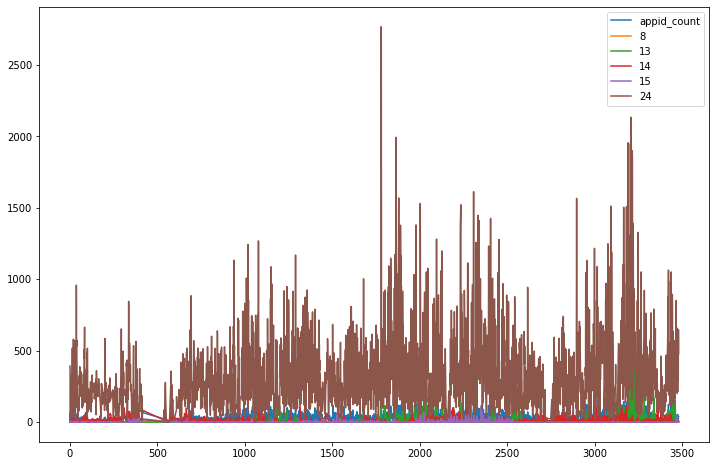

In [440]:
#plot the data
plt.figure(figsize=(12,8))
plot_label = []
plot_label.append('appid_count')
plt.plot(demo_group_dt['appid_count']) 
range_lst = [8, 13, 14, 15, 24]
for i in range_lst:
    if i!= 16:
        plt.plot(demo_group_dt[i]) 
        plot_label.append(i)

plt.legend(plot_label)
plt.show()

In [3]:
#plot reference
'''fig = plt.figure()
ax = fig.add_subplot(111)

A = -0.75, -0.25, 0, 0.25, 0.5, 0.75, 1.0
B = 0.73, 0.97, 1.0, 0.97, 0.88, 0.73, 0.54

ax.plot(A,B)
for xy in zip(A, B):                                       # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') # <--

ax.grid()
plt.show()

# X and Y data
numberofemp_A = [13, 200, 250, 300, 350, 400]
numberofemp_B = [10, 100, 150, 200, 250, 800]
year = [2011, 2012, 2013, 2014, 2015, 2016]

# plot a line chart
plt.plot(year, numberofemp_A, marker='D', mfc='green', mec='yellow',ms='7')
plt.plot(year, numberofemp_B, marker='o', mfc='red', mec='green',ms='7')

# set label name of x-axis title
plt.xlabel("Year")

# set label name of x-axis title
plt.ylabel("Number of Employees")

# set label name of chart title
plt.title("Number of Employee V/s Year Growth")

plt.legend(['numberofemp_A','numberofemp_B'])
plt.show()'''

'fig = plt.figure()\nax = fig.add_subplot(111)\n\nA = -0.75, -0.25, 0, 0.25, 0.5, 0.75, 1.0\nB = 0.73, 0.97, 1.0, 0.97, 0.88, 0.73, 0.54\n\nax.plot(A,B)\nfor xy in zip(A, B):                                       # <--\n    ax.annotate(\'(%s, %s)\' % xy, xy=xy, textcoords=\'data\') # <--\n\nax.grid()\nplt.show()\n\n# X and Y data\nnumberofemp_A = [13, 200, 250, 300, 350, 400]\nnumberofemp_B = [10, 100, 150, 200, 250, 800]\nyear = [2011, 2012, 2013, 2014, 2015, 2016]\n\n# plot a line chart\nplt.plot(year, numberofemp_A, marker=\'D\', mfc=\'green\', mec=\'yellow\',ms=\'7\')\nplt.plot(year, numberofemp_B, marker=\'o\', mfc=\'red\', mec=\'green\',ms=\'7\')\n\n# set label name of x-axis title\nplt.xlabel("Year")\n\n# set label name of x-axis title\nplt.ylabel("Number of Employees")\n\n# set label name of chart title\nplt.title("Number of Employee V/s Year Growth")\n\nplt.legend([\'numberofemp_A\',\'numberofemp_B\'])\nplt.show()'

### BI estimation results check

In [5]:
#conducted statistical test
#non-parametrix statistical hypothesis test  
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import scipy.stats as stats

In [8]:
os.listdir()

['to Yiran read h5.ipynb',
 'daysim_outputs.h5',
 'daysim_outputs_scenario_pessimistic.h5',
 'Daysim Input Data File Documentation.docx',
 'Documentation of DaySim changes to handle AVs and paid ride share mode.docx',
 'DaySim kiss and ride implementation notes.docx',
 'Daysim model variable descriptions.xlsx',
 'Daysim2.1 Users Guide.xlsx',
 "DaySim Developer's Guide.docx",
 'DaySim Standard Technical Documentation.docx',
 'taz2010region.zip',
 'taz2010.shx',
 'taz2010.dbf',
 'taz2010.prj',
 'taz2010.sbn',
 'taz2010.sbx',
 'taz2010.shp',
 'taz2010.shp.xml',
 'taz2010_revised.shp',
 'taz2010_revised.shx',
 'taz2010_revised.dbf',
 'taz2010_revised.cpg',
 'taz2010_revised.prj',
 'taz2010_revised.qpj',
 'home_psrc_withtaz.csv',
 'missing_taz_check.qgz',
 'taz2010_joinedctcb.shp',
 'taz2010_joinedctcb.shx',
 'taz2010_joinedctcb.dbf',
 'taz2010_joinedctcb.cpg',
 'taz2010_joinedctcb.prj',
 'taz2010_joinedctcb.qpj',
 'ACS_2017_count_dt.csv',
 'demo_group_dt_fullinocme.csv',
 'demo_group_dt.cs

In [40]:
demo_group_dt_landuse_hm.columns

Index(['TAZ', 'demo_level_1', 'demo_level_2', 'demo_level_3', 'demo_level_4',
       'demo_level_5', 'demo_level_6', 'demo_level_7', 'demo_level_8',
       'demo_level_9',
       ...
       'demo6_est_per', 'demo7_est_per', 'demo8_est_per', 'demo9_est_per',
       'demo10_est_per', 'demo11_est_per', 'demo12_est_per', 'demo13_est_per',
       'demo14_est_per', 'demo15_est_per'],
      dtype='object', length=214)

In [367]:
BI_est_result = pd.read_csv('result_v1_all.csv', nrows=31)
#BI_est_result = pd.read_csv('fit_result_sim_all.csv', nrows=31)

In [10]:
BI_est_result_all = pd.read_csv('result_v1_all.csv', nrows=31)
BI_est_result_age = pd.read_csv('fit_result_age.csv', nrows=16)
BI_est_result_age_c6 = pd.read_csv('fit_result_agec6.csv', nrows=16)

demo_group_dt_landuse_hm = pd.read_csv('demo_group_dt_land_use_hm.csv', index_col=0)

#select part of the data
demo_group_dt_landuse_hm = demo_group_dt_landuse_hm[['TAZ', 'demo_level_1', 'demo_level_2', 'demo_level_3','demo_level_4', 
                                                    'demo_level_5', 'demo_level_6', 'demo_level_7','demo_level_8', 
                                                    'demo_level_9', 'demo_level_10', 'demo_level_11','demo_level_12', 
                                                    'demo_level_13', 'demo_level_14', 'demo_level_15','demo_level_16',
                                                    'demo_level_17', 'demo_level_18', 'demo_level_19','demo_level_20', 
                                                    'demo_level_21', 'demo_level_22', 'demo_level_23','demo_level_24', 
                                                    'demo_level_25', 'demo_level_26', 'demo_level_27','demo_level_28', 
                                                    'demo_level_29', 'demo_level_30', 'appid_count','psrc_sum','sumup_psrc_demo', 
                                                    'sum_demo_rate','demo1', 'demo2', 'demo3','demo4', 'demo5', 
                                                    'demo6', 'demo7', 'demo8', 'demo9', 'demo10','demo11', 'demo12', 
                                                    'demo13', 'demo14', 'demo15', 'demo_age_1','demo_age_2', 'demo_age_3', 
                                                    'demo_age_4', 'demo_age_5','demo_age_6', 'demo_age_7', 'demo_age_8', 
                                                    'demo_age_9','demo_age_10', 'demo_age_11', 'demo_age_12', 'demo_age_13',
                                                    'demo_age_14', 'demo_age_15', 'demo_age_16', 'demo_age_17','demo_age_18', 
                                                    'demo_age_19', 'demo_age_20', 'demo_age_21','demo_age_22', 'demo_age_23',
                                                    'demo_age_24', 'rate_cut_jenkc4', 'rate_cut_jenkc5', 'rate_cut_jenkc6']]

In [198]:
BI_sim_input = pd.read_csv('person_BI_all.csv', index_col=0)
BI_sim_est = pd.read_csv('fit_result_sim_all.csv', nrows=31)
BI_sim_input.columns

Index(['TAZ', 'app_count', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7',
       'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17',
       'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27',
       'd28', 'd29', 'pop', 'dng0', 'dng1', 'dng2', 'dng3', 'dng4', 'dng5',
       'dng6', 'dng7', 'dng8', 'dng9', 'dng10', 'dng11', 'dng12', 'dng13',
       'dng14'],
      dtype='object')

In [314]:
#defined functions
def get_colname(selected_colnames):
    per_names = []
    for i in selected_colnames:
        per_names.append(i+'_per')
    return(per_names)

def get_per(demo_dt, selected_colnames, sum_col):
    per_names = get_colname(selected_colnames)
    for i in range(len(selected_colnames)):
        demo_dt[per_names[i]] = demo_dt[selected_colnames[i]]/demo_dt[sum_col]  
        
#input = demo_dt, selected_col, bi_est, est_sum_col
def get_est_per(demo_dt, selected_col, bi_est, est_sum_col, add_est_col):
    new_est = []
    for i in range(len(bi_est)):
        new_col = selected_col[i]+add_est_col
        new_est.append(new_col)
        demo_dt[new_col] = demo_dt[selected_col[i]]*bi_est[i] 
    demo_dt[est_sum_col] = np.sum(demo_dt[new_est], axis=1)
    get_per(demo_dt, new_est, est_sum_col)
    
def get_data_mean(demo_dt, selected_col):
    mean_val = list(demo_dt[selected_col].describe().T[['mean']].values.T)
    return(mean_val)

def get_test(est, act):
    print(ks_2samp(est, act))
    print(mannwhitneyu(est, act))

def check_negative(est, cur):
    if False in ((cur-est)>0):
        print('warning, pop exists est > cur')
        
def get_index(labels, indexes):
    selected_demo = []
    for i in indexes:
        selected_demo.append(labels[i])
    return(selected_demo)

def demo_est_diff(est, cur, demo_label):
    diff = cur - est
    positive_index = np.where(diff>0)[0]
    negative_index = np.where(diff<0)[0]
    print('under estimated demo group')
    print(get_index(demo_label, positive_index))
    print('over estimated demo group')
    print(get_index(demo_label, negative_index))

In [200]:
colnames = demo_group_dt_landuse_hm.columns

get_per(demo_group_dt_landuse_hm, colnames[1:31], 'sumup_psrc_demo')
get_per(demo_group_dt_landuse_hm, colnames[35: 50], 'sumup_psrc_demo')

get_est_per(demo_group_dt_landuse_hm, colnames[1:31], list(BI_est_result_all['mean'].values)[:-1], 'estsumall')
get_est_per(demo_group_dt_landuse_hm, colnames[35:50], list(BI_est_result_age['mean'].values)[:-1], 'estsumage')

colnames = np.array(demo_group_dt_landuse_hm.columns)

In [255]:
demo_group_dt_landuse_hm[demo_group_dt_landuse_hm.columns[-62:-31]]

,estsumall,demo_level_1_est_per,demo_level_2_est_per,demo_level_3_est_per,demo_level_4_est_per,demo_level_5_est_per,demo_level_6_est_per,demo_level_7_est_per,demo_level_8_est_per,demo_level_9_est_per,...,demo_level_21_est_per,demo_level_22_est_per,demo_level_23_est_per,demo_level_24_est_per,demo_level_25_est_per,demo_level_26_est_per,demo_level_27_est_per,demo_level_28_est_per,demo_level_29_est_per,demo_level_30_est_per
0,564.169034,0.001311,0.110840,0.004421,0.000000,0.018923,0.000000,0.002549,0.063045,0.016247,...,0.000000,0.002514,0.044752,0.010838,0.007416,0.130300,0.018425,0.012598,0.077808,0.002701
1,894.331852,0.015713,0.120177,0.000372,0.013305,0.045510,0.003580,0.017152,0.087157,0.010249,...,0.000000,0.040174,0.088013,0.010256,0.053466,0.073438,0.003874,0.059604,0.036118,0.000000
2,1421.634082,0.010145,0.021077,0.000000,0.036123,0.072747,0.000000,0.033382,0.048708,0.000679,...,0.000000,0.087789,0.033848,0.000614,0.068531,0.049590,0.000406,0.144628,0.031169,0.000000
3,1226.442545,0.008744,0.010622,0.000000,0.045446,0.055492,0.000000,0.033223,0.035171,0.001180,...,0.000000,0.083259,0.023008,0.000712,0.067741,0.045691,0.000000,0.179236,0.033766,0.000000
4,355.482362,0.017685,0.073295,0.001403,0.036996,0.146403,0.002252,0.021576,0.100056,0.005428,...,0.000000,0.035906,0.076037,0.004915,0.036991,0.074581,0.003249,0.018566,0.010485,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,540.419969,0.010264,0.138612,0.003384,0.019700,0.022224,0.001481,0.005322,0.066516,0.000000,...,0.002708,0.012247,0.062108,0.004041,0.003318,0.078048,0.009618,0.010333,0.047510,0.000000
3477,977.365306,0.010216,0.079976,0.002382,0.007689,0.022528,0.000819,0.007357,0.052265,0.000000,...,0.002995,0.016446,0.049537,0.003128,0.010396,0.117136,0.008272,0.019219,0.071607,0.003638
3478,426.486953,0.019943,0.105385,0.001949,0.011747,0.023467,0.000000,0.007868,0.060330,0.000000,...,0.003432,0.012193,0.055717,0.003072,0.005606,0.101723,0.004062,0.008333,0.068941,0.000000
3479,1010.545481,0.005123,0.103133,0.002797,0.004958,0.066026,0.000000,0.004269,0.058038,0.000000,...,0.000000,0.007953,0.047029,0.002593,0.011238,0.124619,0.008001,0.028133,0.064748,0.000503


In [223]:
BI_sim_input['sum'] = np.sum(BI_sim_input[BI_colnames[2:32]], axis=1)


In [225]:
get_per(BI_sim_input, BI_colnames[2:32], 'sum')

In [322]:
BI_colnames = BI_sim_input.columns
mean_val = get_data_mean(BI_sim_input, BI_colnames[-30:])
get_est_per(BI_sim_input, BI_colnames[2:32], 
            list(BI_sim_est['mean'].values)[:-1], 'estsumall', '_per')
get_est_per(BI_sim_input, BI_colnames[2:32], 
            list(BI_est_result_all['mean'].values)[:-1], 'estall', '_appper')

In [323]:
BI_colnames = BI_sim_input.columns

In [324]:
len(BI_colnames)

231

In [331]:
#BI_sim_input[BI_sim_input.columns[-30:]]
#BI_sim_input[BI_colnames[-90:-60]]

In [332]:
mean_val_sim = get_data_mean(BI_sim_input, BI_colnames[-90:-60])
est_per_all_sim = get_data_mean(BI_sim_input, BI_colnames[-30:])

In [334]:
est_per_all_sim

[array([0.01856844, 0.08042337, 0.00200664, 0.02512047, 0.06998513,
        0.0022739 , 0.025021  , 0.07079643, 0.00538304, 0.02138285,
        0.11940927, 0.00760306, 0.02145945, 0.06553679, 0.00154528,
        0.02594791, 0.08980064, 0.00303319, 0.02392972, 0.05033547,
        0.00229853, 0.02518945, 0.05158218, 0.00515949, 0.02570142,
        0.08876488, 0.00647016, 0.03185263, 0.03183873, 0.00158045])]

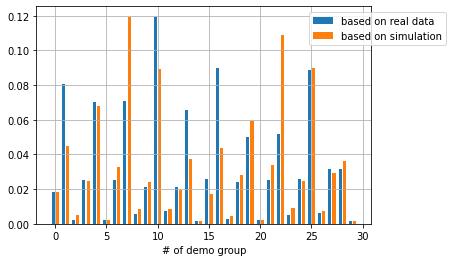

In [358]:
x_val = list(range(1, 31))
x_axis = np.arange(len(x_val))
fig = plt.figure()
ax2 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax2.bar(x_axis-0.2, est_per_all_sim[0], 0.3, label='based on real data')
ax2.bar(x_axis+0.2, mean_val_sim[0][:30], 0.3, label='based on simulation')
ax2.set_xlabel('# of demo group')
#ax2.legend(bbox_to_anchor=(1, -0.5))
ax2.legend(bbox_to_anchor=(0.8, 0.8))
ax2.grid()

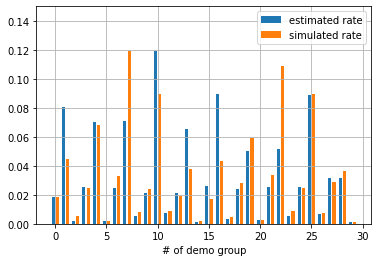

In [410]:
x_val = list(range(1, 31))
x_axis = np.arange(len(x_val))
fig = plt.figure()
ax2 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax2.bar(x_axis-0.2, est_per_all_sim[0], 0.3, label='estimated rate')
ax2.bar(x_axis+0.2, mean_val_sim[0][:30], 0.3, label='simulated rate')
ax2.set_xlabel('# of demo group')
ax2.set_ylim(0, 0.15)
ax2.legend(bbox_to_anchor=(1, 1))
ax2.grid()

Text(0, 0.5, 'est rate of diff demo groups based on simulation data')

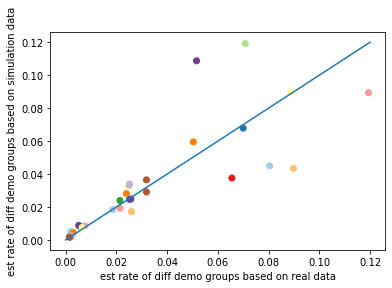

In [420]:
x_val = list(range(1, 31))
fig = plt.figure()
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax3.scatter(est_per_all_sim[0], mean_val_sim[0][:30], c=x_val, cmap='Paired')
ax3.plot([0,.12], [0,.12])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.set_xlabel('est rate of diff demo groups based on real data')
ax3.set_ylabel('est rate of diff demo groups based on simulation data')

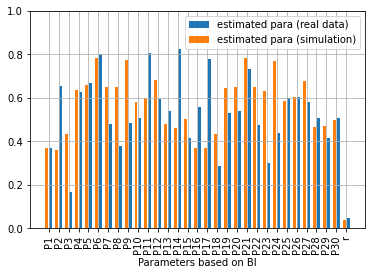

In [419]:
x_val = list(range(1, 31))
x_val = ['P'+str(i) for i in x_val]
x_val.append('r')
x_axis = np.arange(len(x_val))
fig = plt.figure()
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')

ax3.bar(x_axis+0.2, BI_est_result['mean'].values, 0.3, label='estimated para (real data)')
ax3.bar(x_axis-0.2, BI_sim_est['mean'].values, 0.3, label='estimated para (simulation)')
ax3.set_xlabel('Parameters based on BI')

ax3.set_xticks(x_axis, x_val, rotation=90)
ax3.set_ylim(0, 1.)
ax3.legend(bbox_to_anchor=(1, 1))
ax3.grid()

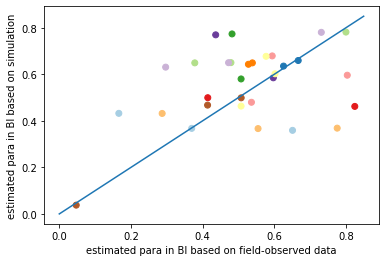

In [389]:
x_axis = np.arange(31)
fig = plt.figure()
ax3 = plt.subplot(111)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax3.scatter(BI_est_result['mean'].values, BI_sim_est['mean'].values, c=x_axis, cmap='Paired')

ax3.set_ylabel('estimated para in BI based on simulation')
ax3.set_xlabel('estimated para in BI based on field-observed data')
ax3.plot([0,.85], [0,.85])
#ax3.legend(bbox_to_anchor=(1.55, 1))


In [422]:
get_test(est_per_all_sim[0], mean_val_sim[0][:30])
get_test(BI_sim_est['mean'].values, BI_est_result_all['mean'].values)

KstestResult(statistic=0.1, pvalue=0.9988393756362763)
MannwhitneyuResult(statistic=439.0, pvalue=0.8766349003139949)
KstestResult(statistic=0.22580645161290322, pvalue=0.41354510011947465)
MannwhitneyuResult(statistic=533.0, pvalue=0.4641161849282355)


In [ ]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency([est_per_all_sim[0], mean_val[0][:30]])


stat, p, dof, expected = chi2_contingency([BI_sim_est['mean'].values, BI_est_result_all['mean'].values])

In [14]:
mean_val = get_data_mean(demo_group_dt_landuse_hm, colnames[77:122])

est_per_all = get_data_mean(demo_group_dt_landuse_hm, colnames[153:183])
est_per_age = get_data_mean(demo_group_dt_landuse_hm, colnames[199:214])

cur_pop = get_data_mean(demo_group_dt_landuse_hm, colnames[1:31])[0]
cur_pop_age = get_data_mean(demo_group_dt_landuse_hm, colnames[35:50])[0]

est_all = get_data_mean(demo_group_dt_landuse_hm, colnames[122:152])[0]
est_age = get_data_mean(demo_group_dt_landuse_hm, colnames[183:198])[0]

0.0400505743358902
0.044021390572449005


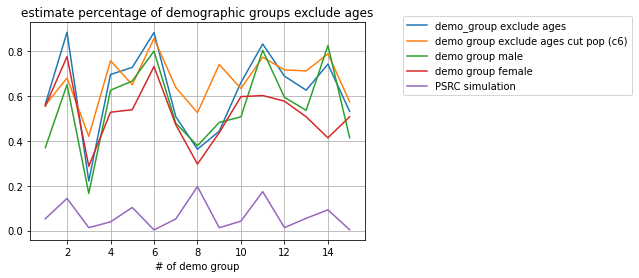

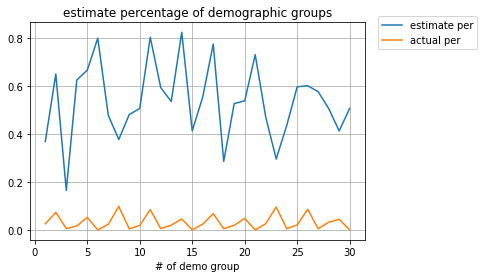

In [15]:
#Notice that for the estimation
#we estimate that given the demographic group population
#the percentage of the pop using/owning smartphones
x_val = list(range(1, 16)) 

fig = plt.figure()
ax1 = plt.subplot(111)

ax1.set_title('estimate percentage of demographic groups exclude ages')
ax1.plot(x_val, list(BI_est_result_age['mean'].values)[:15],
         label= 'demo_group exclude ages')
ax1.plot(x_val, list(BI_est_result_age_c6['mean'].values)[:15],
         label='demo group exclude ages cut pop (c6)')
ax1.plot(x_val, list(BI_est_result_all['mean'].values)[:15], label='demo group male')
ax1.plot(x_val, list(BI_est_result_all['mean'].values)[15:30], label='demo group female')
ax1.plot(x_val, mean_val[0][30:], label='PSRC simulation')
ax1.set_xlabel('# of demo group')

ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.grid()

print(BI_est_result_age['mean'].values[-1])
print(BI_est_result_age_c6['mean'].values[-1])
######################################################################

fig = plt.figure()
ax2 = plt.subplot(111)
x_val = list(range(1, 31))
ax2.set_title('estimate percentage of demographic groups')
ax2.plot(x_val, list(BI_est_result_all['mean'].values)[:30], label='estimate per')
ax2.plot(x_val, mean_val[0][:30], label='actual per')
ax2.set_xlabel('# of demo group')
ax2.legend(bbox_to_anchor=(1.35, 1.05))
ax2.grid()
#######################################################################


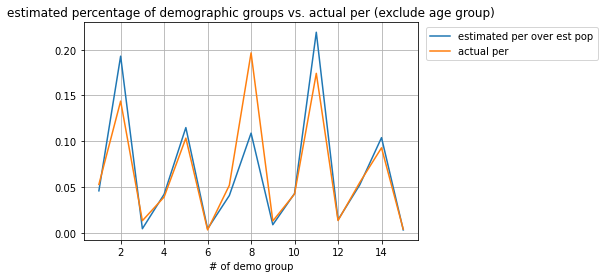

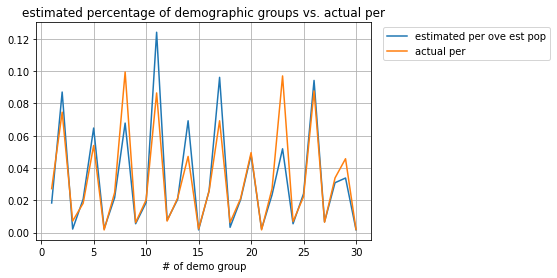

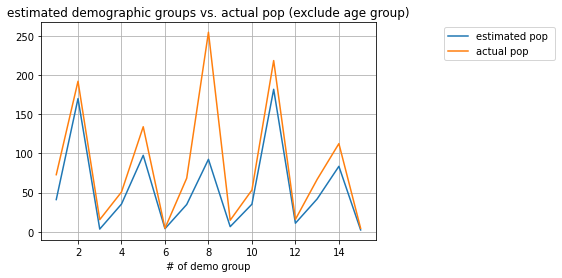

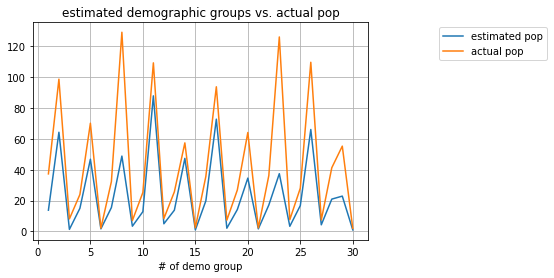

In [16]:
fig = plt.figure()
ax1 = plt.subplot(111)
x_val = list(range(1, 16))
ax1.set_title('estimated percentage of demographic groups vs. actual per (exclude age group)')
ax1.plot(x_val, est_per_age[0], label='estimated per over est pop')
ax1.plot(x_val, mean_val[0][30:], label='actual per')
ax1.set_xlabel('# of demo group')
ax1.legend(bbox_to_anchor=(1.55, 1))
ax1.grid()

fig = plt.figure()
ax2 = plt.subplot(111)
x_val = list(range(1, 31))
ax2.set_title('estimated percentage of demographic groups vs. actual per')
ax2.plot(x_val, est_per_all[0], label='estimated per ove est pop')
ax2.plot(x_val, mean_val[0][:30], label='actual per')
ax2.set_xlabel('# of demo group')
ax2.legend(bbox_to_anchor=(1.55, 1))
ax2.grid()

fig = plt.figure()
ax3 = plt.subplot(111)
x_val = list(range(1, 16))
ax3.set_title('estimated demographic groups vs. actual pop (exclude age group)')
ax3.plot(x_val, est_age, label='estimated pop ')
ax3.plot(x_val, cur_pop_age, label='actual pop')
ax3.set_xlabel('# of demo group')
ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.grid()

fig = plt.figure()
ax4 = plt.subplot(111)
x_val = list(range(1, 31))
ax4.set_title('estimated demographic groups vs. actual pop')
ax4.plot(x_val, est_all, label='estimated pop')
ax4.plot(x_val, cur_pop, label='actual pop')
ax4.set_xlabel('# of demo group')
ax4.legend(bbox_to_anchor=(1.55, 1))
ax4.grid()

1.0000000000000009

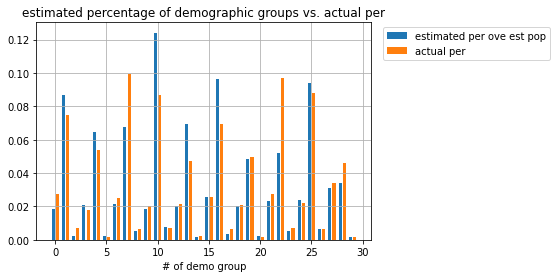

In [26]:
x_val = list(range(1, 31))
x_axis = np.arange(len(x_val))
fig = plt.figure()
ax2 = plt.subplot(111)
ax2.set_title('estimated percentage of demographic groups vs. actual per')
ax2.bar(x_axis-0.2, est_per_all[0], 0.3, label='estimated per over est pop')
ax2.bar(x_axis+0.2, mean_val[0][:30], 0.3, label='actual per')
ax2.set_xlabel('# of demo group')
ax2.legend(bbox_to_anchor=(1.55, 1))
ax2.grid()

In [11]:
age_level = ['<18', '18-29', '30-49', '50-64', '>65']
income_level = ['low income', 'medium income', 'high income']
gender_level = ['male', 'female']

demo_label = []
for g in gender_level:
    for a in age_level:
        for i in income_level:
            demo_label.append(g+','+i+','+a)
            
demo_label_age = []
for a in age_level:
    for i in income_level:
        demo_label_age.append(i+','+a)

In [12]:
#check if any estimated population larger than the actual pop
check_negative(est_age, cur_pop_age)
check_negative(est_all, cur_pop)

#just a reference since we use the mean values
demo_est_diff(est_per_all[0], mean_val[0][:30], demo_label)
demo_est_diff(est_per_age[0], mean_val[0][30:], demo_label_age)

under estimated demo group
['male,low income,<18', 'male,high income,<18', 'male,low income,30-49', 'male,medium income,30-49', 'male,high income,30-49', 'male,low income,50-64', 'male,low income,>65', 'male,high income,>65', 'female,high income,<18', 'female,low income,18-29', 'female,medium income,18-29', 'female,low income,30-49', 'female,medium income,30-49', 'female,high income,30-49', 'female,low income,>65', 'female,medium income,>65', 'female,high income,>65']
over estimated demo group
['male,medium income,<18', 'male,low income,18-29', 'male,medium income,18-29', 'male,high income,18-29', 'male,medium income,50-64', 'male,high income,50-64', 'male,medium income,>65', 'female,low income,<18', 'female,medium income,<18', 'female,high income,18-29', 'female,low income,50-64', 'female,medium income,50-64', 'female,high income,50-64']
under estimated demo group
['low income,<18', 'high income,<18', 'low income,30-49', 'medium income,30-49', 'high income,30-49', 'low income,>65', 'h

In [13]:
get_test(est_age, cur_pop_age)
get_test(est_all, cur_pop)


KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
MannwhitneyuResult(statistic=83.0, pvalue=0.22902896662469463)
KstestResult(statistic=0.36666666666666664, pvalue=0.034580084963334506)
MannwhitneyuResult(statistic=316.0, pvalue=0.048413499464813624)


#### simulation based on variance

In [18]:
def generate_val(mean, sd, min_val, max_val, random_num):
    #np.random.seed(123)
    dist = stats.truncnorm((min_val - mean) / sd, (max_val - mean) / sd, loc=mean, scale=sd)
    values = dist.rvs(random_num)
    return(np.mean(values))

def get_valbydt(demo_dt, selected_col, random_num):
    sum_dt = demo_dt[selected_col].describe().T
    avg_val = sum_dt['mean'].values
    sd_val = sum_dt['std'].values
    min_val = sum_dt['min'].values
    max_val = sum_dt['max'].values
    sim_val = []
    for i in range(len(avg_val)):
        sim_val.append(generate_val(avg_val[i], sd_val[i], min_val[i], max_val[i], random_num))
    return(sim_val)

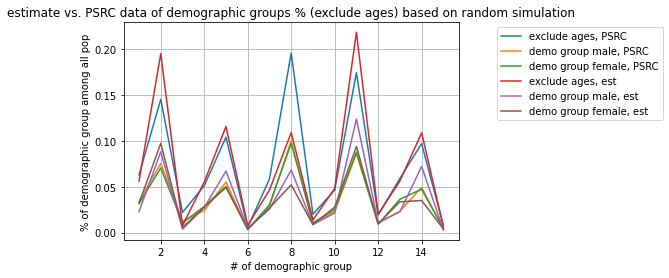

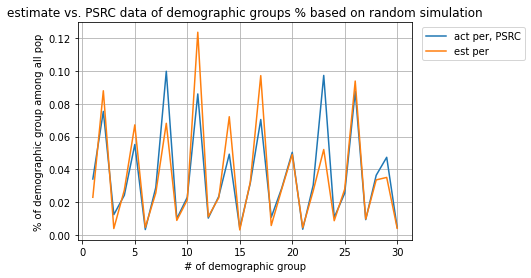

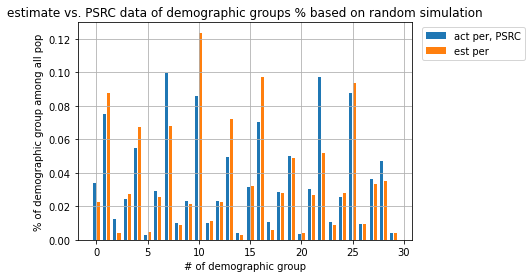

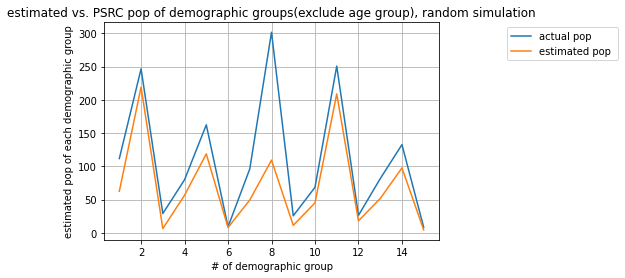

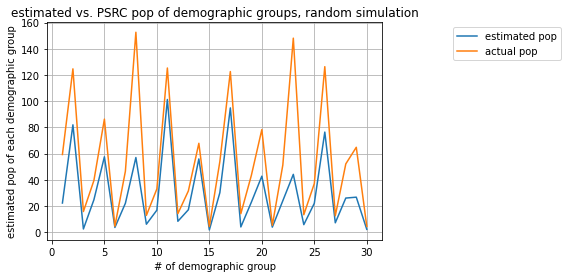

In [39]:
sim_num = 10000
test_pop = get_valbydt(demo_group_dt_landuse_hm, colnames[1:31], sim_num)
test_pop_age = get_valbydt(demo_group_dt_landuse_hm, colnames[35:50], sim_num)
test_estpop_all = get_valbydt(demo_group_dt_landuse_hm, colnames[122:152], sim_num)
test_estpop_age = get_valbydt(demo_group_dt_landuse_hm, colnames[183:198], sim_num)

test_per = get_valbydt(demo_group_dt_landuse_hm, colnames[77:122], sim_num)
test_est_per_all = get_valbydt(demo_group_dt_landuse_hm, colnames[153:183], sim_num)
test_est_per_age = get_valbydt(demo_group_dt_landuse_hm, colnames[199:214], sim_num)

#test_est_per_age

fig = plt.figure()
ax1 = plt.subplot(111)

x_val = list(range(1, 16)) 
ax1.set_title('estimate vs. PSRC data of demographic groups % (exclude ages) based on random simulation')
ax1.plot(x_val, test_per[-15:],  label= 'exclude ages, PSRC')
ax1.plot(x_val, test_per[:15], label='demo group male, PSRC')
ax1.plot(x_val, test_per[15:-15], label='demo group female, PSRC')
ax1.plot(x_val, test_est_per_age, label='exclude ages, est')
ax1.plot(x_val, test_est_per_all[:15], label='demo group male, est')
ax1.plot(x_val, test_est_per_all[15:], label='demo group female, est')
ax1.set_xlabel('# of demographic group')
ax1.set_ylabel('% of demographic group among all pop')
ax1.legend(bbox_to_anchor=(1.1, 1))
ax1.grid()

######################################################################

fig = plt.figure()
ax2 = plt.subplot(111)
x_val = list(range(1, 31))
ax2.set_title('estimate vs. PSRC data of demographic groups % based on random simulation')
ax2.plot(x_val, test_per[:30], label='act per, PSRC')
ax2.plot(x_val, test_est_per_all, label='est per')
ax2.set_xlabel('# of demographic group')
ax2.set_ylabel('% of demographic group among all pop')
ax2.legend(bbox_to_anchor=(1.35, 1))
ax2.grid()

fig = plt.figure()
ax22 = plt.subplot(111)
x_val = list(range(1, 31))
ax22.set_title('estimate vs. PSRC data of demographic groups %')
x_axis = np.arange(len(x_val))
ax22.bar(x_axis-0.2, test_per[:30], 0.3, label='act per, PSRC')
ax22.bar(x_axis+0.2, test_est_per_all, 0.3, label='est per')
ax22.set_xlabel('# of demographic group')
ax22.set_ylabel('% of demographic group among all pop')
ax22.legend(bbox_to_anchor=(1.35, 1))
ax22.grid()

fig = plt.figure()
ax3 = plt.subplot(111)
x_val = list(range(1, 16))
ax3.set_title('estimated vs. PSRC pop of demographic groups(exclude age group), random simulation')
ax3.plot(x_val, test_pop_age, label='actual pop')
ax3.plot(x_val, test_estpop_age, label='estimated pop ')
ax3.set_xlabel('# of demographic group')
ax3.set_ylabel('estimated pop of each demographic group')
ax3.legend(bbox_to_anchor=(1.55, 1))
ax3.grid()

fig = plt.figure()
ax4 = plt.subplot(111)
x_val = list(range(1, 31))
ax4.set_title('estimated vs. PSRC pop of demographic groups, random simulation')
ax4.plot(x_val, test_estpop_all, label='estimated pop')
ax4.plot(x_val, test_pop, label='actual pop')
ax4.set_xlabel('# of demographic group')
ax4.set_ylabel('estimated pop of each demographic group')
ax4.legend(bbox_to_anchor=(1.55, 1))
ax4.grid()

In [16]:
get_test(test_estpop_age, test_pop_age)
get_test(test_estpop_all, test_pop)

KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
MannwhitneyuResult(statistic=81.0, pvalue=0.1985058531538877)
KstestResult(statistic=0.36666666666666664, pvalue=0.034580084963334506)
MannwhitneyuResult(statistic=304.0, pvalue=0.03146563257725609)


In [477]:
#check if any estimated population larger than the actual pop
check_negative(np.array(test_estpop_age), np.array(test_pop_age))
check_negative(np.array(test_estpop_all), np.array(test_pop))

#just a reference since we use the mean values
demo_est_diff(np.array(test_est_per_age), np.array(test_per[-15:]), demo_label_age)
demo_est_diff(np.array(test_est_per_all), np.array(test_per[:30]), demo_label)

under estimated demo group
['low income,<18', 'high income,<18', 'low income,30-49', 'medium income,30-49', 'high income,30-49', 'low income,>65', 'high income,>65']
over estimated demo group
['medium income,<18', 'low income,18-29', 'medium income,18-29', 'high income,18-29', 'low income,50-64', 'medium income,50-64', 'high income,50-64', 'medium income,>65']
under estimated demo group
['male,low income,<18', 'male,high income,<18', 'male,low income,30-49', 'male,medium income,30-49', 'male,high income,30-49', 'male,low income,50-64', 'male,low income,>65', 'male,high income,>65', 'female,high income,<18', 'female,low income,18-29', 'female,medium income,18-29', 'female,low income,30-49', 'female,medium income,30-49', 'female,high income,30-49', 'female,low income,>65', 'female,medium income,>65', 'female,high income,>65']
over estimated demo group
['male,medium income,<18', 'male,low income,18-29', 'male,medium income,18-29', 'male,high income,18-29', 'male,medium income,50-64', 'mal

## Draft code
### draft code for SUMO Seattle TAZ extract

In [ ]:
#draft code for downtown Seattle TAZ extract

#get downtown Seattle taz
#transfer sumo xml
input_taz_sumo_file = 'G:/Shared drives/SUMO Seattle Simulation Model/Seattle Network/Bigger Seattle\Traffic signal\test\test_network_with_transit_n_veh_ped'
tree = ET.parse('')
root = tree.getroot()

#get traffic signal info
sumo_signal_info = {}
sumoids = list(available_id['sumoid'])
sumo_network_ids = []
for connection in root.findall('connection'):
    #get the tlLogic_ids
    tlLogic_ids = connection.get('tl')
    if tlLogic_ids not in sumo_network_ids:
        sumo_network_ids.append(tlLogic_ids)
    if tlLogic_ids in sumoids:
        if tlLogic_ids not in sumo_signal_info:
            sumo_signal_info[tlLogic_ids] = {}
        connection_index = connection.get('linkIndex')
        sumo_signal_info[tlLogic_ids][connection_index] = {}
        sumo_signal_info[tlLogic_ids][connection_index]['dir'] = connection.get('dir')
        sumo_signal_info[tlLogic_ids][connection_index]['fromEdge'] = connection.get('from')
        sumo_signal_info[tlLogic_ids][connection_index]['fromLane'] = connection.get('fromLane')
        sumo_signal_info[tlLogic_ids][connection_index]['toEdge'] = connection.get('to')
        sumo_signal_info[tlLogic_ids][connection_index]['toLane'] = connection.get('toLane')
#sort index
for sumoid in sumo_signal_info:
    sumo_signal_info[sumoid] = sortindexnum(sumoid)

### **Write the scenario back to h5 file**

In [20]:
# save modified tables back to (a new) h5 file
def df_to_h5(h5, df, group_name):

    f = h5py.File(h5, 'r+')
    grp = f.create_group(group_name)

    for column in df.columns:
        if column in ['travdist','travcost','travtime','trexpfac',
        'tautotime','tautocost','tautodist','toexpfac','hdexpfac'
        'pwautime','pwaudist', 'psautime','psaudist','psexpfac',
        'pdexpfac', 'hhexpfac'
        ]:
            grp.create_dataset(column, data=list(df[column].astype('float64')))
        else:
            grp.create_dataset(column, data=list(df[column].astype('int32')))

    print("Added to h5 container: " + str(group_name))

    f.close()
    
# output_path = r'\\modelstation3\c$\Workspace\sc_new_emp_SCEN3_2018'
# Write out scenarios
fname = 'daysim_outputs_scenario_pessimistic.h5'
#output_dir = os.path.join(output_path,fname)
output_dir = fname

if os.path.isfile(output_dir):
    os.remove(output_dir)
f = h5py.File(output_dir, 'w')

df_to_h5(output_dir, trips, "Trip")
df_to_h5(output_dir, tours, "Tour")
df_to_h5(output_dir, person, "Person")
df_to_h5(output_dir, person_day, "PersonDay")
df_to_h5(output_dir, hh, "Household")
df_to_h5(output_dir, hh_day, "HouseholdDay")

# trips
f.close()

Added to h5 container: Trip
Added to h5 container: Tour
Added to h5 container: Person
Added to h5 container: PersonDay
Added to h5 container: Household
Added to h5 container: HouseholdDay
